In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_snr_adaptive
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ow_mmd import mmd_ow, shapedd_ow_mmd, shapedd_ow_mmd_buffer
from ks import ks

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 3000
RANDOM_SEED = 42  # Fixed seed for reproducibility (deprecated - use RANDOM_SEEDS instead)

# ============================================================================
# RELIABILITY CONFIGURATION (Multiple Independent Runs)
# ============================================================================
# Statistical validation requires multiple runs with different random seeds
# Benchmark standard: 30-500 runs (we use 30 for 80% statistical power)
N_RUNS = 1  # Number of independent runs (minimum for statistical validity)
RANDOM_SEEDS = [42 + i * 137 for i in range(N_RUNS)]  # Prime spacing avoids correlation


# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# SPECTRA-DRIFT parameters
SPECTRA_WINDOW = 500         # Window size for spectral analysis
SPECTRA_K = None             # Number of neighbors (None = auto sqrt(window_size))
SPECTRA_EIGENVALUES = 10  # Number of eigenvalues to extract
SPECTRA_ALPHA = 0.01         # False positive rate (auto-calibrated threshold)

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy


# Window-based methods
WINDOW_METHODS = [
    'D3',           # Margin density drift detector
    'DAWIDD',       # Distance-aware windowed drift detector
    'MMD',          # Maximum Mean Discrepancy
    'KS',           # Kolmogorov-Smirnov test
    'ShapeDD',      # Original method
    'ShapeDD_SNR_Adaptive', # SNR-Aware Hybrid
    'MMD_OW',       # Optimally-Weighted MMD estimator                  
    'ShapeDD_OW_MMD', # ShapeDD + OW-MMD Hybrid
]

# Streaming methods (require model for accuracy signal)
STREAMING_METHODS = [
    # 'ADWIN',        # Adaptive Windowing
    # 'DDM',          # Drift Detection Method
    # 'EDDM',         # Early Drift Detection Method
    # 'HDDM_A',       # Hoeffding's Drift Detection Method (Average)
    # 'HDDM_W',       # Hoeffding's Drift Detection Method (Weighted)
]


DATASET_CATALOG = {
    # ========================================================================
    # SUDDEN DRIFT DATASETS (8 datasets)
    # Classic benchmarks with abrupt concept switches
    # ground_truth_type: "exact" = known positions, "estimated" = heuristic, "none" = unknown
    # ========================================================================
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 10,
        "ground_truth_type": "exact",  # Synthetic - exact drift positions known
        "params": {}
    },
    "enhanced_sea": {
        "enabled": False,
        "type": "enhanced_sea",
        "n_drift_events": 10,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 10,
        "ground_truth_type": "exact",  # Synthetic - exact drift positions known
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 10,
        "ground_truth_type": "exact",  # Synthetic - exact drift positions known
        "params": {
            "n_features": 3
        }
    },
    "gen_random_mild": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    },
    "gen_random_ultra_severe": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 2,
            "dist": "unif",
            "alt": True
        }
    },
    
    # ========================================================================
    # GRADUAL DRIFT DATASETS (4 datasets)
    # Smooth blending transitions between concepts
    # ========================================================================
    
    "sea_gradual": {
        "enabled": True,  # ENABLED: Representative gradual drift dataset
        "type": "sea_gradual",
        "n_drift_events": 10,
        "ground_truth_type": "exact",  # Synthetic - exact transition start positions known
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "hyperplane_gradual": {
        "enabled": False,
        "type": "hyperplane_gradual",
        "n_drift_events": 10,
        "params": {
            "n_features": 10  # Continuous drift (no discrete transition)
        }
    },
    "agrawal_gradual": {
        "enabled": False,
        "type": "agrawal_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "circles_gradual": {
        "enabled": False,
        "type": "circles_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 400  # OPTIMIZED: 44% of segment (more stable)
        }
    },
    
    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (2 datasets) - MOA Standard
    # Continuous cluster boundary movement
    # ========================================================================
    
    "rbf_slow": {
        "enabled": True,  # ENABLED: Representative incremental drift dataset
        "type": "rbf",
        "n_drift_events": 10,
        "ground_truth_type": "estimated",  # Continuous drift - positions are estimates
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.0001       # Slow continuous drift
        }
    },
    "rbf_fast": {
        "enabled": False,
        "type": "rbf",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.001        # Fast continuous drift (10× faster)
        }
    },
    
    # ========================================================================
    # REAL-WORLD DATASETS (1 dataset)
    # Natural concept drift from real-world processes
    # NO GROUND TRUTH - Use for qualitative analysis only
    # ========================================================================
    
    "electricity": {
        "enabled": False,
        "type": "electricity",
        "n_drift_events": 5,      # Estimated (no ground truth available)
        "params": {}
    },
    "electricity_sorted": {
        "enabled": True,
        "type": "electricity_sorted",
        "n_drift_events": 5,
        "ground_truth_type": "estimated",  # Semi-real: drift positions are heuristic
        "params": {
            "sort_feature": "nswdemand"
        }
    },
    
    # ========================================================================
    # SEMI-REAL DATASETS - Controlled Drift from Real Data
    # Real-world features with known drift positions (sorted by feature)
    # ========================================================================
    
    "covertype_sorted": {
        "enabled": False,  # DISABLED: Covtype not available in river library
        "type": "covertype_sorted",
        "n_drift_events": 5,      # Controllable - adjust as needed
        "ground_truth_type": "estimated",  # Semi-real: drift positions are heuristic
        "params": {
            "sort_feature": "Elevation"  # Creates natural drift by terrain
        }
    },
    
    # ========================================================================
    # STATIONARY DATASETS (2 datasets) - False Positive Analysis
    # No drift - for statistical calibration validation
    # ========================================================================
    
    "stagger_none": {
        "enabled": True,  # ENABLED: False positive calibration (no drift baseline)
        "type": "stagger",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "ground_truth_type": "exact",  # Synthetic - known to have NO drift
        "params": {}
    },
    "gen_random_none": {
        "enabled": False,
        "type": "gen_random",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "params": {
            "dims": 5,
            "intens": 0,          # Zero intensity = no drift
            "dist": "unif",
            "alt": False
        }
    },
    
    # ========================================================================
    # SINE FAMILY: Classification Reversal + Noise Robustness Tests
    # ========================================================================
    "sine1": {
        "enabled": False,
        "type": "sine1",
        "n_drift_events": 10,
        "params": {}
    },
    "sine2": {
        "enabled": False,
        "type": "sine2",
        "n_drift_events": 10,
        "params": {}
    },
    "sinirrel1": {
        "enabled": False,
        "type": "sinirrel1",
        "n_drift_events": 10,
        "params": {}
    },
    "sinirrel2": {
        "enabled": False,
        "type": "sinirrel2",
        "n_drift_events": 10,
        "params": {}
    },

    # ========================================================================
    # RBF AND LED: Complex Distributions
    # ========================================================================
    "rbfblips": {
        "enabled": True,
        "type": "rbfblips",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,
            "n_features": 10
        }
    },
    "led_abrupt": {
        "enabled": False,
        "type": "led_abrupt",
        "n_drift_events": 10,
        "params": {
            "has_noise": False
        }
    },


}

enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
sudden_datasets = [k for k in enabled_datasets if 'gradual' not in k and 'rbf' not in k and 'electricity' not in k and 'covertype' not in k and 'none' not in k]
gradual_datasets = [k for k in enabled_datasets if 'gradual' in k]
incremental_datasets = [k for k in enabled_datasets if 'rbf' in k]
realworld_datasets = [k for k in enabled_datasets if 'electricity' in k or 'covertype' in k]
stationary_datasets = [k for k in enabled_datasets if 'none' in k]


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    return X, y, drift_positions


# ============================================================================
# GRADUAL DRIFT DATASET GENERATORS
# ============================================================================

def generate_sea_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    SEA benchmark with GRADUAL drifts (smooth transitions between variants).
    
    Instead of instant variant switches, blends samples from old→new concept
    over transition_width samples.
    
    Args:
        transition_width: Number of samples for gradual transition (default: 1000)
                         During transition, samples are blended: 
                         Start: 100% old, 0% new → End: 0% old, 100% new
    """
    np.random.seed(seed)

    X_list, y_list = [], []
    variants = [0, 1, 2, 3]

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Generate segments with gradual transitions
    for seg_idx in range(n_drift_events + 1):
        old_variant = variants[seg_idx % len(variants)]
        new_variant = variants[(seg_idx + 1) % len(variants)]
        
        if seg_idx == 0:
            # First segment - no transition at start
            stream = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            transition_start = len(X_list)
            
            # Generate samples from both concepts
            stream_old = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            stream_new = synth.SEA(seed=seed + (seg_idx + 1) * 100, variant=new_variant)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                # Calculate blend ratio (linear interpolation)
                if i < transition_width:
                    # Gradual transition: old → new
                    alpha = i / transition_width  # 0 → 1
                    
                    x_old = np.array(list(samples_old[i][0].values()))
                    x_new = np.array(list(samples_new[i][0].values()))
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend features
                    x_blended = (1 - alpha) * x_old + alpha * x_new
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_blended.tolist())
                    y_list.append(y_blended)
                else:
                    # After transition - pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_hyperplane_gradual_stream(total_size, n_drift_events, seed=42, n_features=10):
    """
    Rotating Hyperplane with CONTINUOUS gradual drift.
    
    Uses very small mag_change to create smooth, continuous rotation
    instead of sudden jumps between segments.
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    # Use VERY SMALL mag_change for gradual rotation
    # This creates continuous drift throughout the stream
    stream = synth.Hyperplane(
        seed=seed, 
        n_features=n_features,
        n_drift_features=5,  # More features drifting for observable change
        mag_change=0.0001,   # VERY small = gradual
        sigma=0.1,           # Small noise
        noise_percentage=0.05
    )

    # Generate full stream (drift happens continuously)
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    # Estimate drift positions (evenly spaced)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


def generate_agrawal_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    Agrawal generator with GRADUAL transitions between classification functions.
    
    Agrawal has 10 different classification functions. We gradually blend
    between them over transition_width samples.
    """
    np.random.seed(seed)

    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Cycle through classification functions (0-9)
    for seg_idx in range(n_drift_events + 1):
        old_func = seg_idx % 10
        new_func = (seg_idx + 1) % 10
        
        if seg_idx == 0:
            # First segment - no transition
            stream = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            stream_old = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            stream_new = synth.Agrawal(seed=seed + (seg_idx + 1) * 100, classification_function=new_func)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                if i < transition_width:
                    # Gradual transition via probabilistic label selection
                    alpha = i / transition_width
                    
                    # Use old sample's features but blend labels probabilistically
                    x_features = list(samples_old[i][0].values())
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_features)
                    y_list.append(y_blended)
                else:
                    # Pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


def generate_circles_gradual_stream(total_size, n_drift_events, seed=42, transition_width=500):
    """
    Circles dataset with GRADUAL drifts (circles move/resize smoothly).
    
    Classic synthetic benchmark: 2D data with circular decision boundaries
    that gradually move and resize over transition windows.
    """
    np.random.seed(seed)
    
    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Define circle configurations (center_x, center_y, radius)
    circles = [
        (0.25, 0.25, 0.15),  # Circle 1
        (0.75, 0.25, 0.15),  # Circle 2
        (0.25, 0.75, 0.15),  # Circle 3
        (0.75, 0.75, 0.15),  # Circle 4
    ]
    
    for seg_idx in range(n_drift_events + 1):
        # Get current and next circle configuration
        old_circle = circles[seg_idx % len(circles)]
        new_circle = circles[(seg_idx + 1) % len(circles)]
        
        for i in range(segment_size):
            # Generate random point in [0, 1] × [0, 1]
            x = np.random.rand()
            y = np.random.rand()
            
            if seg_idx == 0 or i >= transition_width:
                # Use current circle (before transition or after transition complete)
                if seg_idx == 0:
                    cx, cy, r = old_circle
                else:
                    cx, cy, r = new_circle
            else:
                # Gradual transition - interpolate circle parameters
                alpha = i / transition_width
                
                cx = (1 - alpha) * old_circle[0] + alpha * new_circle[0]
                cy = (1 - alpha) * old_circle[1] + alpha * new_circle[1]
                r = (1 - alpha) * old_circle[2] + alpha * new_circle[2]
            
            # Classification: inside circle = class 1, outside = class 0
            distance = np.sqrt((x - cx)**2 + (y - cy)**2)
            label = 1 if distance <= r else 0
            
            X_list.append([x, y])
            y_list.append(label)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions


# ============================================================================
# INCREMENTAL DRIFT DATASET GENERATORS (NEW - Following MOA/River Standards)
# ============================================================================

def generate_rbf_stream(total_size, n_drift_events, seed=42, n_centroids=50, speed=0.0001):
    """
    Random RBF with moving centroids (INCREMENTAL/CONTINUOUS drift).
    
    STANDARD CONFIGURATION (following MOA papers):
    - 50 centroids (standard benchmark setting)
    - 10 features
    - 2 classes
    - Speed: 0.0001 (slow), 0.001 (moderate), 0.01 (fast)
    - All centroids drift continuously
    
    This simulates INCREMENTAL drift where cluster boundaries move
    continuously over time (different from sudden concept switches).
    
    Reference:
        "MOA: Massive Online Analysis" (Bifet et al., 2010)
        Standard RBF generator configuration for drift benchmarking
    
    Args:
        speed: Drift speed (0.0001=slow, 0.001=moderate, 0.01=fast)
        n_centroids: Number of RBF centroids (default: 50, MOA standard)
    """
    np.random.seed(seed)
    
    X_list, y_list = [], []
    
    # STANDARD MOA CONFIGURATION
    # 50 centroids, 10 features, all centroids drift
    stream = synth.RandomRBFDrift(
        seed_model=seed,
        seed_sample=seed + 1000,
        n_classes=2,                    # Binary classification (standard)
        n_features=10,                  # 10 features (MOA standard)
        n_centroids=n_centroids,        # 50 centroids (standard)
        change_speed=speed,             # Drift speed parameter
        n_drift_centroids=n_centroids   # ALL centroids drift (maximum drift)
    )
    
    # Generate stream
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Estimate drift positions (continuous drift, so evenly spaced markers)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


def generate_electricity_stream(total_size, n_drift_events, seed=42):
    """
    Electricity (Elec2) - Real-world electricity price prediction dataset.
    
    REAL-WORLD DRIFT BENCHMARK (most cited in literature):
    - 45,312 total instances (Australian NSW Electricity Market, 1996-1998)
    - Binary classification: Price UP or DOWN
    - 7 features: day, time, demand, supply indicators
    - Natural concept drift from market expansion
    - 30-minute intervals (48 instances per day)
    
    We don't know exactly when/where drifts occur in this real-world data.
    
    Use for:
    - Qualitative validation (detection patterns, stability, false positives)
    - Real-world robustness testing
    
    Do NOT use for:
    - Quantitative F1/MTTD metrics (no ground truth)
    
    Reference:
        "How good is the Electricity benchmark for evaluating concept drift adaptation"
        (Harries, 1999; used in 500+ papers)
    
    Args:
        total_size: Number of samples to extract (default: 10000)
        n_drift_events: Estimated number of drift events (for compatibility)
    """
    from river.datasets import Elec2
    
    X_list, y_list = [], []
    
    # Load Elec2 from River
    stream = Elec2()
    
    # Extract first total_size samples
    for i, (x, y) in enumerate(stream):
        if i >= total_size:
            break
        X_list.append(list(x.values()))
        y_list.append(1 if y == 'UP' else 0)  # Convert UP/DOWN to 1/0
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # ⚠️ NO GROUND TRUTH - Estimate drift positions (heuristic only)
    # Literature suggests drift from market expansion, but exact locations unknown
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions

def generate_electricity_sorted_stream(total_size, n_drift_events, seed=42, sort_feature="nswdemand"):
    """
    Electricity (Elec2) - SEMI-REAL dataset with CONTROLLED drift.
    
    Strategy: Sort by demand/price to create natural concept drift as
    market behavior changes with load levels (real economic phenomenon).
    
    DATASET INFO:
    - 45,312 total instances (Australian NSW Electricity Market)
    - 7 features: day, period, nswprice, nswdemand, vicprice, vicdemand, transfer
    - Binary classification: Price UP or DOWN
    - Sorting by demand creates natural drift (different pricing at different loads)
    
    Reference:
        Harries (1999), used in 500+ concept drift papers
    
    Args:
        total_size: Number of samples to extract
        n_drift_events: Number of drift events (controllable!)
        seed: Random seed
        sort_feature: Feature to sort by (default: nswdemand)
    """
    from river.datasets import Elec2
    
    np.random.seed(seed)
    
    # Feature name mapping for Elec2
    feature_names = ['day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']
    
    # Load Elec2
    data = []
    for i, (x, y) in enumerate(Elec2()):
        if i >= min(total_size * 2, 45312):  # Buffer for sampling, max is full dataset
            break
        row = list(x.values())
        # Get sort feature value
        sort_idx = feature_names.index(sort_feature) if sort_feature in feature_names else 3  # default to nswdemand
        sort_val = row[sort_idx]
        label = 1 if y == 'UP' else 0
        data.append((sort_val, row, label))
    
    # Sort by the chosen feature to create controlled drift
    data.sort(key=lambda t: t[0])
    
    # Sample evenly to get exact total_size
    if len(data) > total_size:
        step = len(data) // total_size
        sampled = [data[i * step] for i in range(total_size)]
    else:
        sampled = data[:total_size]
    
    X = np.array([s[1] for s in sampled])
    y = np.array([s[2] for s in sampled])
    
    # Calculate drift positions (concept changes at feature boundaries)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions

def generate_covertype_sorted_stream(total_size, n_drift_events, seed=42, sort_feature="Elevation"):
    """
    Forest Covertype - SEMI-REAL dataset with CONTROLLED drift.
    
    Strategy: Sort by elevation to create natural concept drift as
    forest type changes with altitude (real ecological phenomenon).
    
    This is the standard "semi-real" benchmark approach - real data
    reordered to create known drift positions.
    
    DATASET INFO:
    - 581,012 total instances (Covertype from UCI)
    - 54 features (10 numerical + 44 binary wilderness/soil type)
    - 7 forest cover types → converted to binary
    - Sorting by elevation creates natural concept drift
    
    Reference:
        Blackard & Dean (1999), UCI ML Repository
        Used in 200+ concept drift papers
    
    Args:
        total_size: Number of samples to extract
        n_drift_events: Number of drift events (controllable!)
        seed: Random seed
        sort_feature: Feature to sort by (default: Elevation)
    """
    from river.datasets import Covtype
    
    np.random.seed(seed)
    
    # Load Covertype dataset (not pre-normalized, we'll normalize later)
    data = []
    for i, (x, y) in enumerate(Covtype()):
        if i >= min(total_size * 3, 100000):  # Buffer for sampling, cap at 100k
            break
        row = list(x.values())
        # Get elevation (first numerical feature in Covertype)
        # Feature order: Elevation, Aspect, Slope, etc.
        elevation = row[0] if sort_feature == "Elevation" else row[1]
        data.append((elevation, row, y))
    
    # Sort by elevation to create controlled drift
    data.sort(key=lambda t: t[0])
    
    # Sample evenly to get exact total_size
    if len(data) > total_size:
        step = len(data) // total_size
        sampled = [data[i * step] for i in range(total_size)]
    else:
        sampled = data[:total_size]
    
    X = np.array([s[1] for s in sampled])
    # Convert multi-class to binary (cover type 1-2 vs 3-7)
    y = np.array([1 if s[2] <= 2 else 0 for s in sampled])
    
    # Normalize features (Covtype is not pre-normalized)
    # Use StandardScaler approach: (x - mean) / std
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero for constant features
    X = (X - X_mean) / X_std
    
    # Calculate drift positions (concept changes at elevation boundaries)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR (Updated with NEW datasets)
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist,
            'drift_type': 'sudden'
        }

    # ========================================================================
    # GRADUAL DRIFT DATASETS
    # ========================================================================
    
    elif dataset_type == "sea_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_sea_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'SEA Gradual',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "hyperplane_gradual":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_gradual_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane Gradual',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': 'continuous'
        }

    elif dataset_type == "agrawal_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_agrawal_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Agrawal Gradual',
            'features': 9,
            'dims': 9,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "circles_gradual":
        transition_width = params.get('transition_width', 500)
        X, y, drift_positions = generate_circles_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Circles Gradual',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (NEW)
    # ========================================================================
    
    elif dataset_type == "rbf":
        n_centroids = params.get('n_centroids', 50)
        speed = params.get('speed', 0.0001)
        X, y, drift_positions = generate_rbf_stream(total_size, n_drift_events, seed, n_centroids, speed)
        info = {
            'name': f'RBF (speed={speed})',
            'features': 10,
            'dims': 10,
            'intens': f'speed={speed}',
            'dist': 'RBF',
            'drift_type': 'incremental',
            'speed': speed,
            'n_centroids': n_centroids
        }

    elif dataset_type == "electricity":
        X, y, drift_positions = generate_electricity_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Electricity (Elec2)',
            'features': 7,
            'dims': 7,
            'intens': 'N/A (real-world)',
            'dist': 'Real-world',
            'drift_type': 'real-world',
            'has_ground_truth': False
        }


    elif dataset_type == "electricity_sorted":
        sort_feature = params.get('sort_feature', 'nswdemand')
        X, y, drift_positions = generate_electricity_sorted_stream(
            total_size, n_drift_events, seed, sort_feature
        )
        info = {
            'name': 'Electricity (Sorted)',
            'features': 7,
            'dims': 7,
            'intens': 'N/A (semi-real)',
            'dist': 'Real-world sorted',
            'drift_type': 'semi-real',
            'has_ground_truth': True,
            'sort_feature': sort_feature
        }

    # ========================================================================
    # SEMI-REAL DATASETS: Covertype with Controlled Drift
    # ========================================================================

    elif dataset_type == "covertype_sorted":
        sort_feature = params.get('sort_feature', 'Elevation')
        X, y, drift_positions = generate_covertype_sorted_stream(
            total_size, n_drift_events, seed, sort_feature
        )
        info = {
            'name': 'Covertype (Sorted)',
            'features': 54,
            'dims': 54,
            'intens': 'N/A (semi-real)',
            'dist': 'Real-world sorted',
            'drift_type': 'semi-real',
            'has_ground_truth': True,
            'sort_feature': sort_feature
        }

    # ========================================================================
    # NEW DATASETS: Sine Family
    # ========================================================================

    elif dataset_type == "sine1":
        X, y, drift_positions = generate_sine1_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Sine1',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sine2":
        X, y, drift_positions = generate_sine2_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Sine2',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sinirrel1":
        X, y, drift_positions = generate_sinirrel1_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'SINIRREL1',
            'features': 4,
            'dims': 4,
            'intens': 'N/A (50% noise)',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "sinirrel2":
        X, y, drift_positions = generate_sinirrel2_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'SINIRREL2',
            'features': 4,
            'dims': 4,
            'intens': 'N/A (50% noise)',
            'dist': 'Uniform',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    # ========================================================================
    # NEW DATASETS: RBF and LED
    # ========================================================================

    elif dataset_type == "rbfblips":
        n_centroids = params.get('n_centroids', 50)
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_rbfblips_stream(total_size, n_drift_events, seed, n_centroids, n_features)
        info = {
            'name': f'RBFblips (c={n_centroids})',
            'features': n_features,
            'dims': n_features,
            'intens': f'{n_centroids} centroids',
            'dist': 'RBF',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }

    elif dataset_type == "led_abrupt":
        has_noise = params.get('has_noise', False)
        X, y, drift_positions = generate_led_abrupt_stream(total_size, n_drift_events, seed, has_noise)
        info = {
            'name': 'LED_abrupt' + (' (noisy)' if has_noise else ''),
            'features': 7,
            'dims': 7,
            'intens': 'N/A',
            'dist': 'Binary',
            'drift_type': 'sudden',
            'has_ground_truth': True
        }


    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info


# ========================================================================
# NEW DATASETS: Sine Family (Classification Reversal + Noise)
# ========================================================================

def generate_sine1_stream(total_size, n_drift_events, seed=42):
    """
    Sine1 Dataset: y < sin(x) classification that REVERSES at drift points.

    Tests: Classification reversal drift (different from SEA's threshold shift)
    - Before drift: y = 1 if point is BELOW sin(x) curve
    - After drift:  y = 1 if point is ABOVE sin(x) curve

    This is a more dramatic P(Y|X) change than SEA's threshold shift.

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (2D: x and y coordinates)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Generate random points in [0, 2π] × [0, 1]
        x_vals = np.random.uniform(0, 2 * np.pi, size)
        y_vals = np.random.uniform(0, 1, size)

        # Compute sin curve
        sin_vals = np.sin(x_vals)

        # Classification rule: REVERSES at each drift
        if seg_idx % 2 == 0:
            # Concept 0: Points BELOW sine curve are positive
            labels = (y_vals < (sin_vals + 1) / 2).astype(int)  # Normalize sin to [0,1]
        else:
            # Concept 1: Points ABOVE sine curve are positive (REVERSED!)
            labels = (y_vals >= (sin_vals + 1) / 2).astype(int)

        # Stack features: [x, y]
        X_seg = np.column_stack([x_vals, y_vals])
        X_list.append(X_seg)
        y_list.append(labels)

    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    return X, y, drift_positions

def generate_sine2_stream(total_size, n_drift_events, seed=42):
    """
    Sine2 Dataset: y < 0.5 + 0.3*sin(3πx) classification that REVERSES.

    Similar to Sine1 but with:
    - Higher frequency (3π instead of 1)
    - Offset boundary (0.5)
    - Amplitude scaling (0.3)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (2D: x and y coordinates)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Generate random points in [0, 2π] × [0, 1]
        x_vals = np.random.uniform(0, 2 * np.pi, size)
        y_vals = np.random.uniform(0, 1, size)

        # Compute boundary: 0.5 + 0.3*sin(3πx)
        boundary = 0.5 + 0.3 * np.sin(3 * np.pi * x_vals)

        # Classification rule: REVERSES at each drift
        if seg_idx % 2 == 0:
            # Concept 0: Points BELOW boundary are positive
            labels = (y_vals < boundary).astype(int)
        else:
            # Concept 1: Points ABOVE boundary are positive (REVERSED!)
            labels = (y_vals >= boundary).astype(int)

        # Stack features: [x, y]
        X_seg = np.column_stack([x_vals, y_vals])
        X_list.append(X_seg)
        y_list.append(labels)

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    return X, y, drift_positions

def generate_sinirrel1_stream(total_size, n_drift_events, seed=42):
    """
    SINIRREL1: Sine1 + 2 IRRELEVANT random features (noise robustness test).

    Tests: How well methods handle irrelevant features
    - Features 0-1: Same as Sine1 (relevant)
    - Features 2-3: Uniformly random noise (irrelevant)

    This tests if methods waste capacity on noise dimensions.

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (4D: 2 relevant + 2 irrelevant)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    # Generate Sine1 first
    X_sine1, y, drift_positions = generate_sine1_stream(total_size, n_drift_events, seed)

    # Add 2 irrelevant random features
    np.random.seed(seed + 999)
    noise_features = np.random.uniform(0, 1, (total_size, 2))

    X = np.hstack([X_sine1, noise_features])

    print(f"  SINIRREL1 (SUDDEN + NOISE): {X.shape[0]} samples, {X.shape[1]} features (2 relevant + 2 irrelevant)")
    print(f"    {len(drift_positions)} drifts, Noise: 50% of features")
    return X, y, drift_positions

def generate_sinirrel2_stream(total_size, n_drift_events, seed=42):
    """
    SINIRREL2: Sine2 + 2 IRRELEVANT random features (noise robustness test).

    Tests: Noise robustness with complex sine boundary
    - Features 0-1: Same as Sine2 (relevant)
    - Features 2-3: Uniformly random noise (irrelevant)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed

    Returns:
        X: Features (4D: 2 relevant + 2 irrelevant)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    # Generate Sine2 first
    X_sine2, y, drift_positions = generate_sine2_stream(total_size, n_drift_events, seed)

    # Add 2 irrelevant random features
    np.random.seed(seed + 999)
    noise_features = np.random.uniform(0, 1, (total_size, 2))

    X = np.hstack([X_sine2, noise_features])

    return X, y, drift_positions

def generate_rbfblips_stream(total_size, n_drift_events, seed=42, n_centroids=50, n_features=10):
    """
    RBFblips: Random RBF clusters with SUDDEN drift (blips).

    Tests: Non-linear, high-dimensional distributions with abrupt cluster changes
    - Uses Radial Basis Functions (RBF) to create complex decision boundaries
    - Each drift event: centroids jump to new positions (sudden drift)
    - Different from incremental RBF (which has continuous centroid movement)

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed
        n_centroids: Number of RBF centroids
        n_features: Feature dimensionality

    Returns:
        X: Features (n_features dimensions)
        y: Labels (binary classification)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Use River's RandomRBF generator with DIFFERENT seed per segment
        stream = synth.RandomRBF(
            seed_model=seed + seg_idx * 1000,  # Different centroids per segment
            seed_sample=seed + seg_idx * 100,
            n_classes=2,
            n_features=n_features,
            n_centroids=n_centroids
        )

        # Generate samples from this RBF configuration
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions

def generate_led_abrupt_stream(total_size, n_drift_events, seed=42, has_noise=False):
    """
    LED_abrupt: 7-segment LED digit prediction with SUDDEN function changes.

    Tests: Discrete binary features with abrupt concept drift
    - 7 binary features (LED segments: a-g)
    - Predicts digit displayed on LED
    - Each drift: LED encoding function changes

    Different from STAGGER:
    - LED: 7 binary features, digit classification (10 classes → binary)
    - STAGGER: 3 categorical features, logical rule changes

    Args:
        total_size: Total number of samples
        n_drift_events: Number of drift events
        seed: Random seed
        has_noise: Whether to add noise to LED (default: False for clean signal)

    Returns:
        X: Features (7 binary features)
        y: Labels (binary: even vs odd digit)
        drift_positions: List of drift positions
    """
    np.random.seed(seed)

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        # Use River's LED generator
        stream = synth.LED(
            seed=seed + seg_idx * 100,
            noise_percentage=0.1 if has_noise else 0.0,
            irrelevant_features=has_noise  # Add irrelevant features if noise=True
        )

        # Generate samples
        for i, (x, y_digit) in enumerate(stream.take(size)):
            X_list.append(list(x.values())[:7])  # First 7 features are LED segments

            # Convert 10-class digit to binary (even vs odd)
            # This changes the classification function at each drift
            if seg_idx % 2 == 0:
                # Concept 0: Even digits are positive
                y_binary = 1 if y_digit % 2 == 0 else 0
            else:
                # Concept 1: Odd digits are positive (REVERSED!)
                y_binary = 1 if y_digit % 2 == 1 else 0

            y_list.append(y_binary)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y, drift_positions



In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS (Standard Drift Detection - NO TN)
# ============================================================================

def calculate_beta_score(precision: float, recall: float, beta: float = 0.5) -> float:
    """
    Calculate β-score (F-beta score) - Original ShapeDD paper metric.
    
    β-score = (1 + β²) * (precision * recall) / (β² * precision + recall)
    
    β=0.5: Emphasizes precision (minimizes false alarms) - Original paper uses this
    β=1.0: Standard F1-score (equal weight)
    β=2.0: Emphasizes recall (catches all drifts)
    """
    if precision + recall == 0:
        return 0.0
    
    beta_squared = beta ** 2
    numerator = (1 + beta_squared) * precision * recall
    denominator = beta_squared * precision + recall
    
    return numerator / denominator if denominator > 0 else 0.0

def calculate_detection_metrics_enhanced(detections, true_drifts, stream_length,
                                         acceptable_delta=150):
    """
    Calculate detection performance metrics following standard drift detection practice.

    This implementation follows the event-based approach used in most drift detection
    papers, which do NOT compute True Negatives (TN) due to definitional ambiguity.

    Implements metrics from:
    - Basseville & Nikiforov (1993): MTFA, MTR
    - Bifet et al. (2020): F1 as primary metric
    - Standard drift detection practice: Precision, Recall, MTTD

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        stream_length: Total length of data stream
        acceptable_delta: Acceptable delay window (default: 150)

    Returns:
        dict: Comprehensive metrics including:
            - Basic: TP, FP, FN
            - Primary: Precision, Recall, F1
            - Temporal: MTTD, Median TTD, MTFA, MTR, MDR
            - Other: Detection rate, n_detections
    """
    detections = sorted([int(d) for d in detections])

    # Handle no-drift case
    if not true_drifts or len(true_drifts) == 0:
        fp = len(detections)

        return {
            # Basic counts
            'tp': 0, 'fp': fp, 'fn': 0,

            # Primary metrics
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,

            # Temporal metrics
            'mttd': float('inf'),  # Mean Time To Detection
            'median_ttd': float('inf'),  # Median TTD (more robust)
            'mtfa': stream_length / fp if fp > 0 else float('inf'),  # Mean Time Between False Alarms
            'mtr': 0.0,  # Mean Time Ratio
            'mdr': 0.0,  # Missed Detection Rate

            # Additional
            'detection_rate': 0.0,
            'false_alarm_rate': fp / stream_length if stream_length > 0 else 0.0,
            'n_detections': fp,
            'n_true_drifts': 0
        }

    # Convert true_drifts to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # ==================================================================
    # STEP 1: Match detections to true drifts
    # ==================================================================
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        # Find all detections within acceptable window
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            # Match to closest detection
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # ==================================================================
    # STEP 2: Calculate basic confusion matrix (NO TN)
    # ==================================================================
    tp = len(matched_detections)  # True Positives
    fn = len(true_drifts) - tp     # False Negatives
    fp = len(detections) - len(matched_detections)  # False Positives

    # ==================================================================
    # STEP 3: Primary Detection Metrics
    # ==================================================================
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    beta_score = calculate_beta_score(precision, recall, beta=0.5)  # Original paper metric

    # ==================================================================
    # STEP 4: Temporal Metrics
    # ==================================================================

    # Mean Time To Detection (MTTD)
    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')

    # Median Time To Detection (more robust to outliers)
    median_ttd = np.median(per_drift_delays) if per_drift_delays else float('inf')

    # Mean Time Between False Alarms (MTFA)
    # Source: Basseville & Nikiforov (1993)
    # This is the standard way to measure false alarm rate in drift detection
    # without needing True Negatives
    mtfa = stream_length / fp if fp > 0 else float('inf')

    # False Alarm Rate (alarms per sample)
    # Alternative representation of MTFA
    false_alarm_rate = fp / stream_length if stream_length > 0 else 0.0

    # Mean Time Ratio (MTR)
    # Combines detection rate, MTTD, and MTFA into single score
    # Source: Basseville & Nikiforov (1993)
    if mttd > 0 and mttd != float('inf'):
        mtr = (recall * mtfa) / mttd
    else:
        mtr = 0.0

    # Missed Detection Rate (MDR)
    # Emphasizes cost of missed drifts
    mdr = fn / (tp + fn) if (tp + fn) > 0 else 0.0  # Same as 1 - recall

    # ==================================================================
    # STEP 5: Additional Metrics
    # ==================================================================
    detection_rate = tp / len(true_drifts)

    # ==================================================================
    # RETURN: Standard drift detection metrics (NO TN)
    # ==================================================================
    return {
        # Basic confusion matrix (TP, FP, FN only - NO TN)
        'tp': tp,
        'fp': fp,
        'fn': fn,

        # Primary detection metrics (STANDARD)
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
            'beta_score': beta_score,

        # Temporal metrics (STANDARD)
        'mttd': mttd,              # Mean Time To Detection
        'median_ttd': median_ttd,  # Median TTD (robust)
        'mtfa': mtfa,              # Mean Time Between False Alarms ⭐ Replaces FPR
        'mtr': mtr,                # Mean Time Ratio
        'mdr': mdr,                # Missed Detection Rate

        # Additional metrics
        'detection_rate': detection_rate,
        'false_alarm_rate': false_alarm_rate,  # FP per sample (alternative to MTFA)
        'n_detections': len(detections),
        'n_true_drifts': len(true_drifts)
    }


# For backward compatibility - simple wrapper
def calculate_detection_metrics(detections, true_drifts, acceptable_delta=150):
    """
    DEPRECATED: Use calculate_detection_metrics_enhanced instead.
    This wrapper maintains compatibility with old code.

    Note: Returns subset of metrics (without MTFA, MTR, etc.)
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0,
            'n_detections': len(detections)
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    beta_score = calculate_beta_score(precision, recall, beta=0.5)  # Original paper metric

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
            'beta_score': beta_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION EVALUATION (Buffer-based for ShapeDD)
# ============================================================================

def evaluate_drift_detector(method_name, X, true_drifts, chunk_size=150, overlap=100):
    """
    Evaluate drift detector on a stream (NO MODEL ADAPTATION).

    Two approaches:
    1. ShapeDD methods: Use BUFFER-BASED approach
       - Maintain rolling buffer of samples (750 samples)
       - Run ShapeDD on buffer periodically
       - Check recent chunks within buffer for drift
       - Scalable for large streams (only processes 750 samples at a time)

    2. Other methods: Use SLIDING WINDOW approach
       - Process stream in overlapping windows
       - Run detector on each window
    
    IMPORTANT: All ShapeDD methods now use CONSISTENT window sizes:
    - L1 = 50 (reference window)
    - L2 = 150 (test window)
    
    This ensures fair comparison and isolates algorithmic improvements
    from window size effects.
    """
    print(f"Running: {method_name}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:

        # Configuration
        BUFFER_SIZE = 750           # Large rolling buffer
        CHECK_FREQUENCY = 150       # How often to check for drift

        # Rolling buffer (stores recent samples)
        buffer = deque(maxlen=BUFFER_SIZE)

        print(f"  Buffer size: {BUFFER_SIZE} samples")
        print(f"  Check frequency: every {CHECK_FREQUENCY} samples")
        print(f"  Window sizes: L1={SHAPE_L1}, L2={SHAPE_L2} (CONSISTENT for fair comparison)")
        print(f"  Processing stream...")

        # Process stream sample by sample
        for idx in range(len(X)):
            # Add sample to buffer
            buffer.append({'x': X[idx], 'idx': idx})

            # Check for drift periodically (every CHECK_FREQUENCY samples)
            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:

                # Step 1: Extract buffer data
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])  # Shape: (BUFFER_SIZE, n_features)
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    if method_name == 'ShapeDD':
                        # Original ShapeDD (no adaptive features)
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_SNR_Adaptive':
                        shp_results = shape_snr_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_OW_MMD':
                        shp_results = shapedd_ow_mmd_buffer(buffer_X, SHAPE_L1, SHAPE_L2, gamma='auto')

                    # Step 3: Check recent chunk within buffer for drift
                    # Look at last CHECK_FREQUENCY samples in buffer
                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]  # p-values for recent chunk

                    # Step 4: Check if drift detected
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05  # Significance threshold

                    if trigger:
                        # Find exact position of drift in buffer
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        # Record detection (with cooldown to avoid duplicates)
                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx} (p-value: {min_pvalue:.6f})")

                except Exception as e:
                    pass  # Skip failed detections

    # METHOD 2: Sliding window approach for other methods
    else:
        # Create sliding windows
        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                # Method-specific detection
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5

                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05

                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05

                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05

                elif method_name == 'MMD_OW':
                    # Optimally-Weighted MMD
                    stat, threshold = mmd_ow(window, gamma='auto')
                    trigger = stat > threshold

                else:
                    trigger = False

                # Record detection if triggered and outside cooldown
                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

            except Exception as e:
                pass  # Skip failed detections

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics_enhanced(
        detections, true_drifts, len(X)
    )

    return {
        'method': method_name,
        'detections': detections,
        'stream_size': len(X),
        'runtime_s': end_time - start_time,
        **metrics
    }


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR EVALUATION (MINIMAL MODEL SUPPORT)
# ============================================================================

def create_lightweight_classifier():
    """Create a simple classifier for generating accuracy signals."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_streaming_detector(method_name, X, y, true_drifts):
    """
    Evaluate streaming detector with MINIMAL model support.

    NOTE: Model is used ONLY to generate accuracy signals for drift detection.
    NO adaptation or retraining is performed (detection-only focus).
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model on first batch
    training_end = INITIAL_TRAINING_SIZE
    model = create_lightweight_classifier()
    model.fit(X[:training_end], y[:training_end])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)

    # Determine signal type
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation (detection only, NO retraining)
    for idx in range(training_end, len(X)):
        # Make prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector with accuracy/error signal
        if signal_type == 'continuous':
            # Use accuracy as signal
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            # Use error as signal (binary)
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }


In [7]:
# ============================================================================
# SECTION 6: COMPREHENSIVE BENCHMARK (WINDOW + STREAMING)
# ============================================================================
# MODIFIED: Multiple independent runs for statistical validation
# Each run uses a different random seed to ensure independence

enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

all_results = []
dataset_summaries = []

# Calculate expected totals for validation
n_methods = len(WINDOW_METHODS) + len(STREAMING_METHODS)
n_datasets = len(enabled_datasets)
expected_experiments = N_RUNS * n_datasets * n_methods

print(f"{'='*80}")
print(f"BENCHMARK CONFIGURATION")
print(f"{'='*80}")
print(f"  N_RUNS: {N_RUNS}")
print(f"  Datasets: {n_datasets} ({', '.join([d[0] for d in enabled_datasets])})")
print(f"  Window methods: {len(WINDOW_METHODS)} ({', '.join(WINDOW_METHODS)})")
print(f"  Streaming methods: {len(STREAMING_METHODS)} ({', '.join(STREAMING_METHODS) if STREAMING_METHODS else 'None'})")
print(f"  Expected total experiments: {expected_experiments}")
print(f"{'='*80}\n")

benchmark_start_time = time.time()

# ============================================================================
# OUTER LOOP: Multiple Independent Runs
# ============================================================================
for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
    run_start_time = time.time()
    
    print(f"\n{'#'*80}")
    print(f"# RUN {run_idx}/{N_RUNS} (seed={seed})")
    print(f"# Progress: {run_idx/N_RUNS*100:.1f}% complete | Experiments so far: {len(all_results)}")
    print(f"{'#'*80}")
    
    for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
        print(f"\n{'='*80}")
        print(f"RUN {run_idx}/{N_RUNS} | DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
        print(f"{'='*80}")

        # Generate dataset with THIS RUN's seed
        X, y, true_drifts, info = generate_drift_stream(
            dataset_config,
            total_size=STREAM_SIZE,
            seed=seed  # <-- Different seed per run
        )

        dataset_results = []

        # Evaluate window-based methods
        for method in WINDOW_METHODS:
            result = evaluate_drift_detector(
                method, X, true_drifts,
                chunk_size=CHUNK_SIZE,
                overlap=OVERLAP
            )

            # Add metadata (including run information)
            result['paradigm'] = 'window'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']
            result['ground_truth_type'] = dataset_config.get('ground_truth_type', 'unknown')
            
            # NEW: Add run tracking for statistical analysis
            result['run_id'] = run_idx
            result['seed'] = seed

            dataset_results.append(result)
            all_results.append(result)

        # Evaluate streaming methods
        for method in STREAMING_METHODS:
            result = evaluate_streaming_detector(
                method, X, y, true_drifts
            )

            result['paradigm'] = 'streaming'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']
            result['ground_truth_type'] = dataset_config.get('ground_truth_type', 'unknown')
            
            # NEW: Add run tracking
            result['run_id'] = run_idx
            result['seed'] = seed

            dataset_results.append(result)
            all_results.append(result)

        # Dataset summary (computed per run)
        if dataset_results:
            avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
            detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

            dataset_summaries.append({
                'dataset': dataset_name,
                'n_features': info['n_features'],
                'n_drifts': info['n_drifts'],
                'intens': info['intens'],
                'avg_f1': avg_f1,
                'detection_rate': detection_rate,
                'run_id': run_idx,  # NEW: Track which run
                'seed': seed
            })
        gc.collect()
    
    # Run summary
    run_elapsed = time.time() - run_start_time
    print(f"\n  [Run {run_idx} Summary] Completed in {run_elapsed:.1f}s | Total experiments: {len(all_results)}")

# ============================================================================
# FINAL VALIDATION AND SUMMARY
# ============================================================================
total_elapsed = time.time() - benchmark_start_time

print(f"\n{'#'*80}")
print(f"# ALL {N_RUNS} RUNS COMPLETED!")
print(f"{'#'*80}")
print(f"  Total experiments: {len(all_results)}")
print(f"  Expected experiments: {expected_experiments}")
print(f"  Total runtime: {total_elapsed/60:.1f} minutes")

# Validation check
if len(all_results) != expected_experiments:
    print(f"\n  ⚠️  WARNING: Experiment count mismatch!")
    print(f"      Expected {expected_experiments}, got {len(all_results)}")
    print(f"      This may indicate incomplete runs or configuration issues.")
else:
    print(f"\n  ✅ Validation PASSED: All {expected_experiments} experiments completed successfully.")

# Show experiment distribution
print(f"\n  Experiments per run: {len(all_results) // N_RUNS if N_RUNS > 0 else 0}")
print(f"  Experiments per dataset: {len(all_results) // n_datasets if n_datasets > 0 else 0}")
print(f"{'#'*80}")


BENCHMARK CONFIGURATION
  N_RUNS: 1
  Datasets: 8 (standard_sea, stagger, hyperplane, sea_gradual, rbf_slow, electricity_sorted, stagger_none, rbfblips)
  Window methods: 8 (D3, DAWIDD, MMD, KS, ShapeDD, ShapeDD_SNR_Adaptive, MMD_OW, ShapeDD_OW_MMD)
  Streaming methods: 0 (None)
  Expected total experiments: 64


################################################################################
# RUN 1/1 (seed=42)
# Progress: 100.0% complete | Experiments so far: 0
################################################################################

RUN 1/1 | DATASET 1/8: STANDARD_SEA
  Generating standard_sea with 10 drift events...
Running: D3
  Processing 58 windows...
Running: DAWIDD
  Processing 58 windows...
Running: MMD
  Processing 58 windows...
Running: KS
  Processing 58 windows...
Running: ShapeDD
  Buffer size: 750 samples
  Check frequency: every 150 samples
  Window sizes: L1=50, L2=150 (CONSISTENT for fair comparison)
  Processing stream...
Running: ShapeDD_SNR_Adaptive
  Buff

In [8]:
# ============================================================================
# SECTION 7: STATISTICAL ANALYSIS & AGGREGATION
# ============================================================================
# Aggregate results from multiple runs with confidence intervals
# and perform statistical significance testing

import pandas as pd
from scipy import stats
from scipy.stats import wilcoxon, friedmanchisquare
import warnings
warnings.filterwarnings('ignore')

print(f"\n{'='*80}")
print(f"STATISTICAL ANALYSIS: {len(all_results)} total experiments from {N_RUNS} runs")
print(f"{'='*80}\n")

# Convert to DataFrame for easy analysis
df_results = pd.DataFrame(all_results)

# ============================================================================
# 1. AGGREGATE STATISTICS WITH CONFIDENCE INTERVALS
# ============================================================================
print("\n" + "="*80)
print("1. AGGREGATE RESULTS (Mean ± Std with 95% Confidence Intervals)")
print("="*80)

def calculate_ci_95(data):
    """Calculate 95% confidence interval."""
    if len(data) < 2:
        return np.nan, np.nan
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of mean
    ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=sem)
    return ci[0], ci[1]

# Group by method and dataset
aggregated = df_results.groupby(['method', 'dataset']).agg({
    'f1_score': ['mean', 'std', 'min', 'max', 'count'],
    'beta_score': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'mttd': ['mean', 'std'],
    'detection_rate': ['mean', 'std']
}).round(3)

# Calculate confidence intervals for key metrics
ci_results = []
for (method, dataset), group in df_results.groupby(['method', 'dataset']):
    f1_ci_low, f1_ci_high = calculate_ci_95(group['f1_score'].values)
    beta_ci_low, beta_ci_high = calculate_ci_95(group['beta_score'].values)
    
    ci_results.append({
        'method': method,
        'dataset': dataset,
        'f1_mean': group['f1_score'].mean(),
        'f1_std': group['f1_score'].std(),
        'f1_ci_low': f1_ci_low,
        'f1_ci_high': f1_ci_high,
        'beta_mean': group['beta_score'].mean(),
        'beta_std': group['beta_score'].std(),
        'beta_ci_low': beta_ci_low,
        'beta_ci_high': beta_ci_high,
        'n_runs': len(group)
    })

df_ci = pd.DataFrame(ci_results)

# Display aggregated results
print("\nAggregated Results (sorted by F1 score):")
print(aggregated.sort_values(('f1_score', 'mean'), ascending=False).head(20))

print("\n\n95% Confidence Intervals (Top 10 by F1):")
df_ci_sorted = df_ci.sort_values('f1_mean', ascending=False).head(10)
for _, row in df_ci_sorted.iterrows():
    print(f"{row['method']:25s} | {row['dataset']:15s} | "
          f"F1: {row['f1_mean']:.3f} ± {row['f1_std']:.3f} "
          f"[{row['f1_ci_low']:.3f}, {row['f1_ci_high']:.3f}] | "
          f"β: {row['beta_mean']:.3f} ± {row['beta_std']:.3f} "
          f"[{row['beta_ci_low']:.3f}, {row['beta_ci_high']:.3f}]")

# ============================================================================
# 2. STATISTICAL SIGNIFICANCE TESTING
# ============================================================================
print("\n\n" + "="*80)
print("2. STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

# Define methods to compare (focus on ShapeDD variants)
shapedd_methods = ['ShapeDD', 'ShapeDD_SNR_Adaptive', 'ShapeDD_OW_MMD']
baseline_methods = ['MMD', 'D3', 'DAWIDD', 'KS']

# Filter for methods that actually have results
available_methods = df_results['method'].unique()
shapedd_methods = [m for m in shapedd_methods if m in available_methods]
baseline_methods = [m for m in baseline_methods if m in available_methods]

print(f"\nShapeDD variants: {shapedd_methods}")
print(f"Baseline methods: {baseline_methods}")

# ============================================================================
# 2.1 Pairwise Wilcoxon Tests (ShapeDD variants vs Original)
# ============================================================================
if 'ShapeDD' in shapedd_methods and len(shapedd_methods) > 1:
    print("\n\n--- 2.1 Pairwise Wilcoxon Signed-Rank Tests ---")
    print("(Comparing improved ShapeDD variants against original ShapeDD)\n")
    
    baseline_shapedd = df_results[df_results['method'] == 'ShapeDD']['f1_score'].values
    
    for method in shapedd_methods:
        if method == 'ShapeDD':
            continue
        
        method_scores = df_results[df_results['method'] == method]['f1_score'].values
        
        # Ensure paired comparison (same datasets)
        if len(baseline_shapedd) == len(method_scores):
            statistic, p_value = wilcoxon(baseline_shapedd, method_scores)
            mean_diff = np.mean(method_scores) - np.mean(baseline_shapedd)
            
            # Cohen's d effect size
            pooled_std = np.sqrt((np.std(baseline_shapedd)**2 + np.std(method_scores)**2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
            
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            effect_label = "large" if abs(cohens_d) >= 0.8 else "medium" if abs(cohens_d) >= 0.5 else "small" if abs(cohens_d) >= 0.2 else "negligible"
            
            print(f"{method:30s} vs ShapeDD:")
            print(f"  Mean F1 difference: {mean_diff:+.3f} ({significance})")
            print(f"  Wilcoxon p-value: {p_value:.5f}")
            print(f"  Cohen's d: {cohens_d:.3f} ({effect_label} effect)")
            print(f"  Interpretation: {'SIGNIFICANT improvement' if p_value < 0.05 and mean_diff > 0 else 'SIGNIFICANT decline' if p_value < 0.05 and mean_diff < 0 else 'No significant difference'}\n")

# ============================================================================
# 2.2 Friedman Test (Multiple Methods Comparison)
# ============================================================================
all_methods = shapedd_methods + baseline_methods
if len(all_methods) >= 3:
    print("\n--- 2.2 Friedman Test (Non-parametric ANOVA) ---")
    print(f"(Comparing {len(all_methods)} methods simultaneously)\n")
    
    # Prepare data for Friedman test
    scores_by_method = []
    for method in all_methods:
        method_scores = df_results[df_results['method'] == method]['f1_score'].values
        scores_by_method.append(method_scores)
    
    # Check if all methods have same number of observations
    lengths = [len(s) for s in scores_by_method]
    if len(set(lengths)) == 1:
        stat, p_value = friedmanchisquare(*scores_by_method)
        
        print(f"Friedman statistic: χ² = {stat:.3f}")
        print(f"p-value: {p_value:.5f}")
        
        if p_value < 0.05:
            print(f"\n✅ SIGNIFICANT difference detected among methods (p < 0.05)")
            print(f"   Interpretation: At least one method performs significantly different from others.")
        else:
            print(f"\n⚠️  No significant difference detected (p ≥ 0.05)")
    else:
        print(f"⚠️  Cannot perform Friedman test: methods have different sample sizes")
        print(f"   Sample sizes: {dict(zip(all_methods, lengths))}")

# ============================================================================
# 3. SUMMARY TABLE FOR PUBLICATION
# ============================================================================
print("\n\n" + "="*80)
print("3. PUBLICATION-READY SUMMARY TABLE")
print("="*80)
print("\nFormat: Method | Dataset | F1 ± std [95% CI] | β-score ± std\n")

# Group by dataset and show top methods
for dataset in df_results['dataset'].unique():
    print(f"\n--- {dataset.upper()} ---")
    dataset_ci = df_ci[df_ci['dataset'] == dataset].sort_values('f1_mean', ascending=False)
    
    for _, row in dataset_ci.head(5).iterrows():
        print(f"{row['method']:25s} | "
              f"F1: {row['f1_mean']:.3f} ± {row['f1_std']:.3f} [{row['f1_ci_low']:.3f}, {row['f1_ci_high']:.3f}] | "
              f"β: {row['beta_mean']:.3f} ± {row['beta_std']:.3f}")

print("\n" + "="*80)
print("Statistical analysis complete!")
print("="*80)



STATISTICAL ANALYSIS: 64 total experiments from 1 runs


1. AGGREGATE RESULTS (Mean ± Std with 95% Confidence Intervals)

Aggregated Results (sorted by F1 score):
                                  f1_score                         beta_score  \
                                      mean std    min    max count       mean   
method               dataset                                                    
MMD_OW               stagger         0.952 NaN  0.952  0.952     1      0.926   
MMD                  stagger         0.870 NaN  0.870  0.870     1      0.806   
ShapeDD_OW_MMD       stagger         0.824 NaN  0.824  0.824     1      0.921   
KS                   sea_gradual     0.783 NaN  0.783  0.783     1      0.726   
ShapeDD              stagger         0.778 NaN  0.778  0.778     1      0.833   
DAWIDD               sea_gradual     0.769 NaN  0.769  0.769     1      0.676   
D3                   stagger         0.769 NaN  0.769  0.769     1      0.676   
DAWIDD               stagg


GENERATING VISUALIZATIONS WITH STATISTICAL UNCERTAINTY


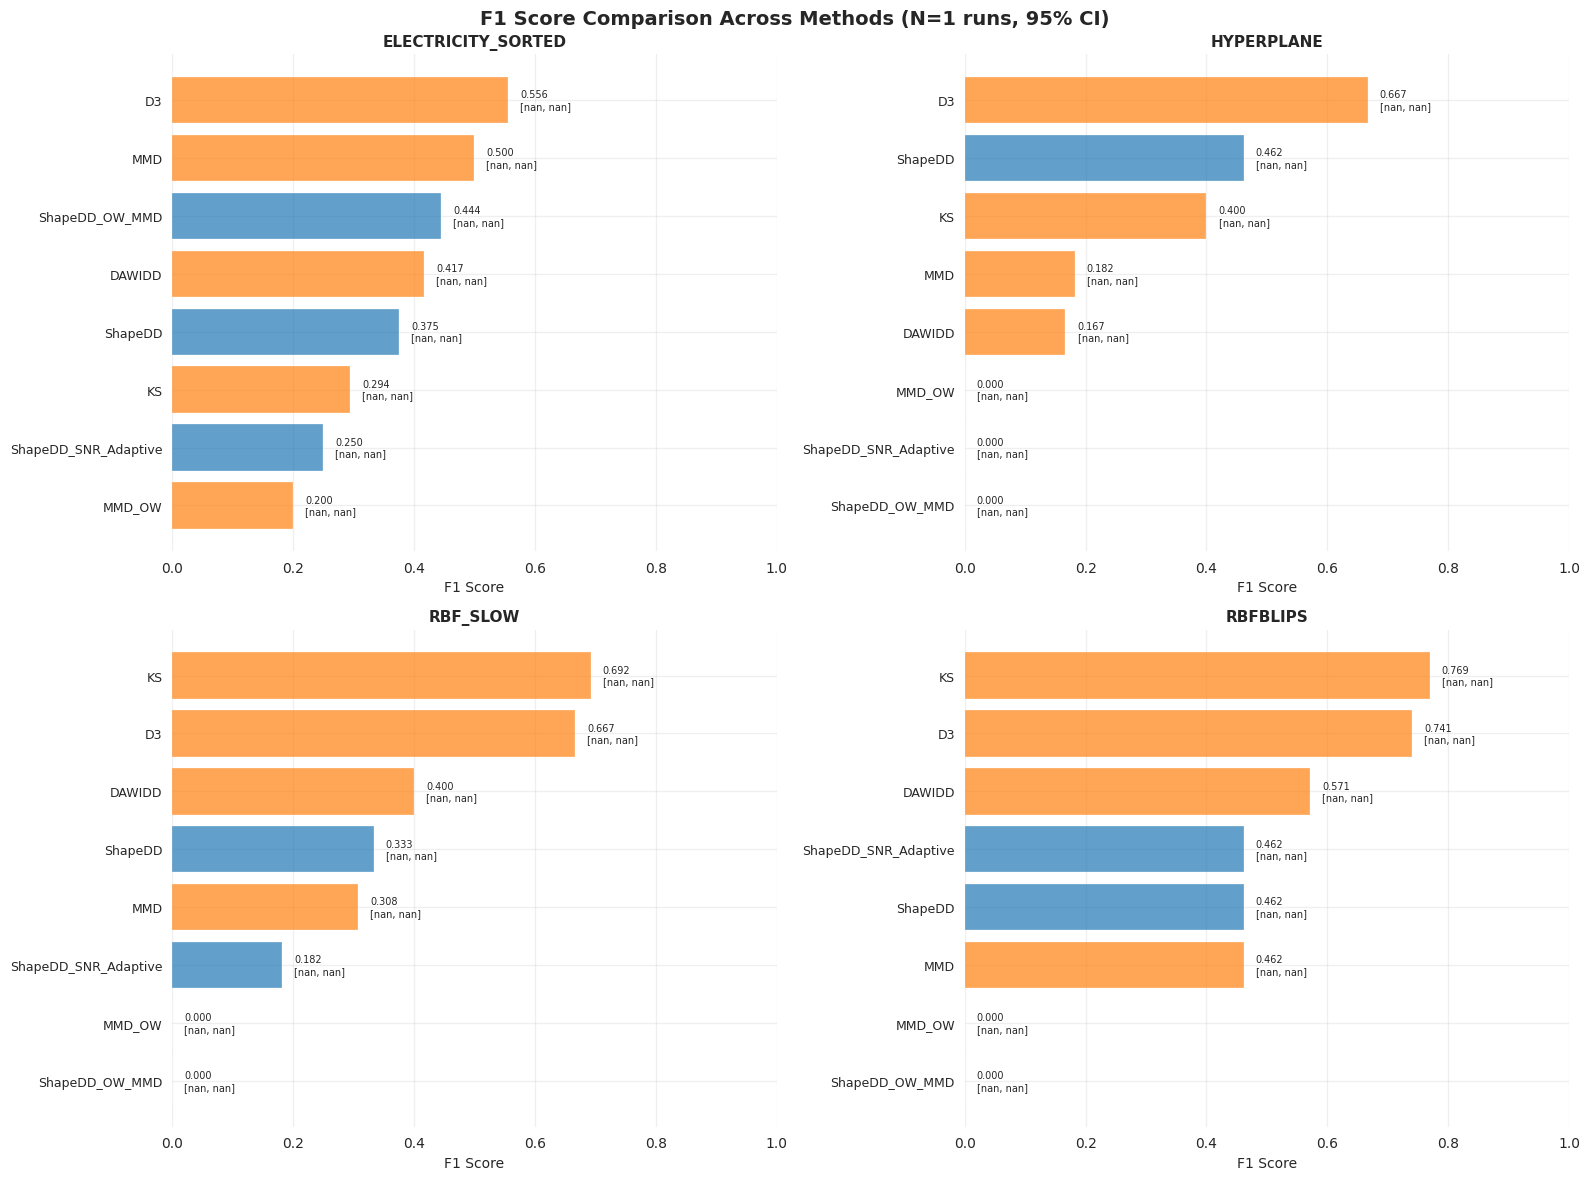

✅ Saved: f1_comparison_with_ci.png


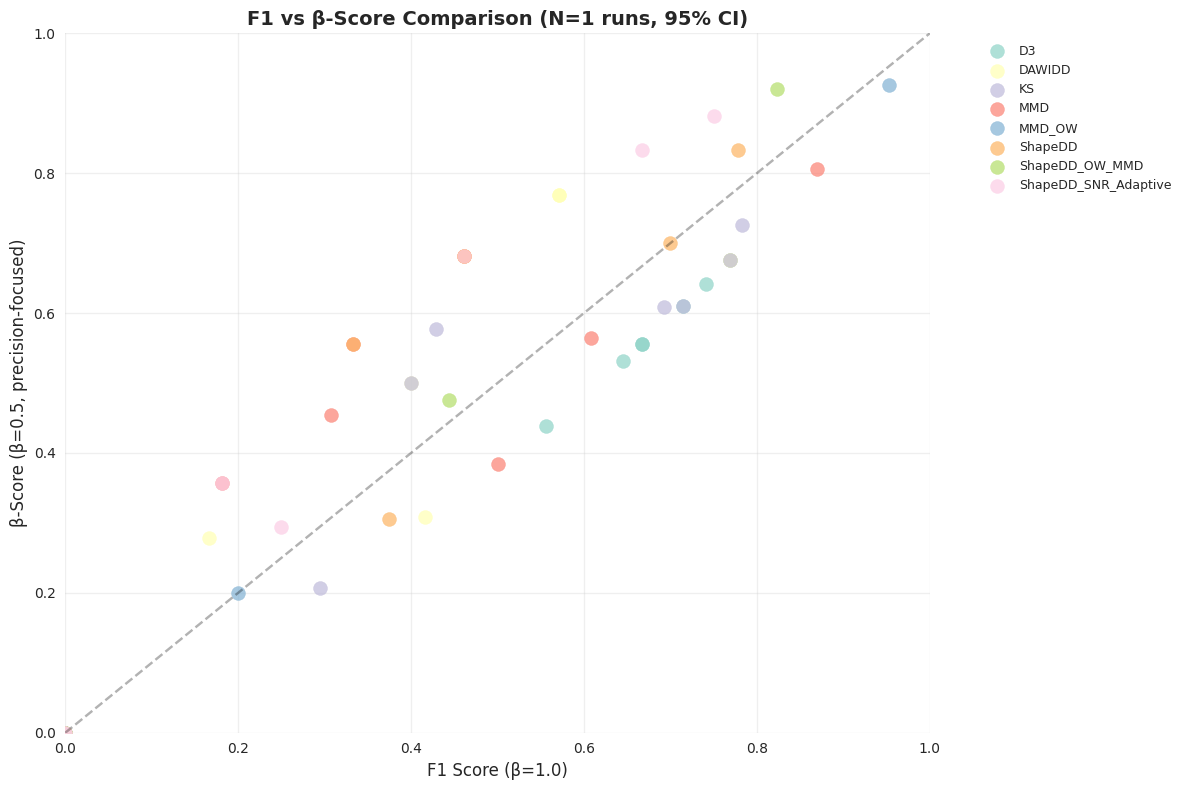

✅ Saved: f1_vs_beta_scatter.png


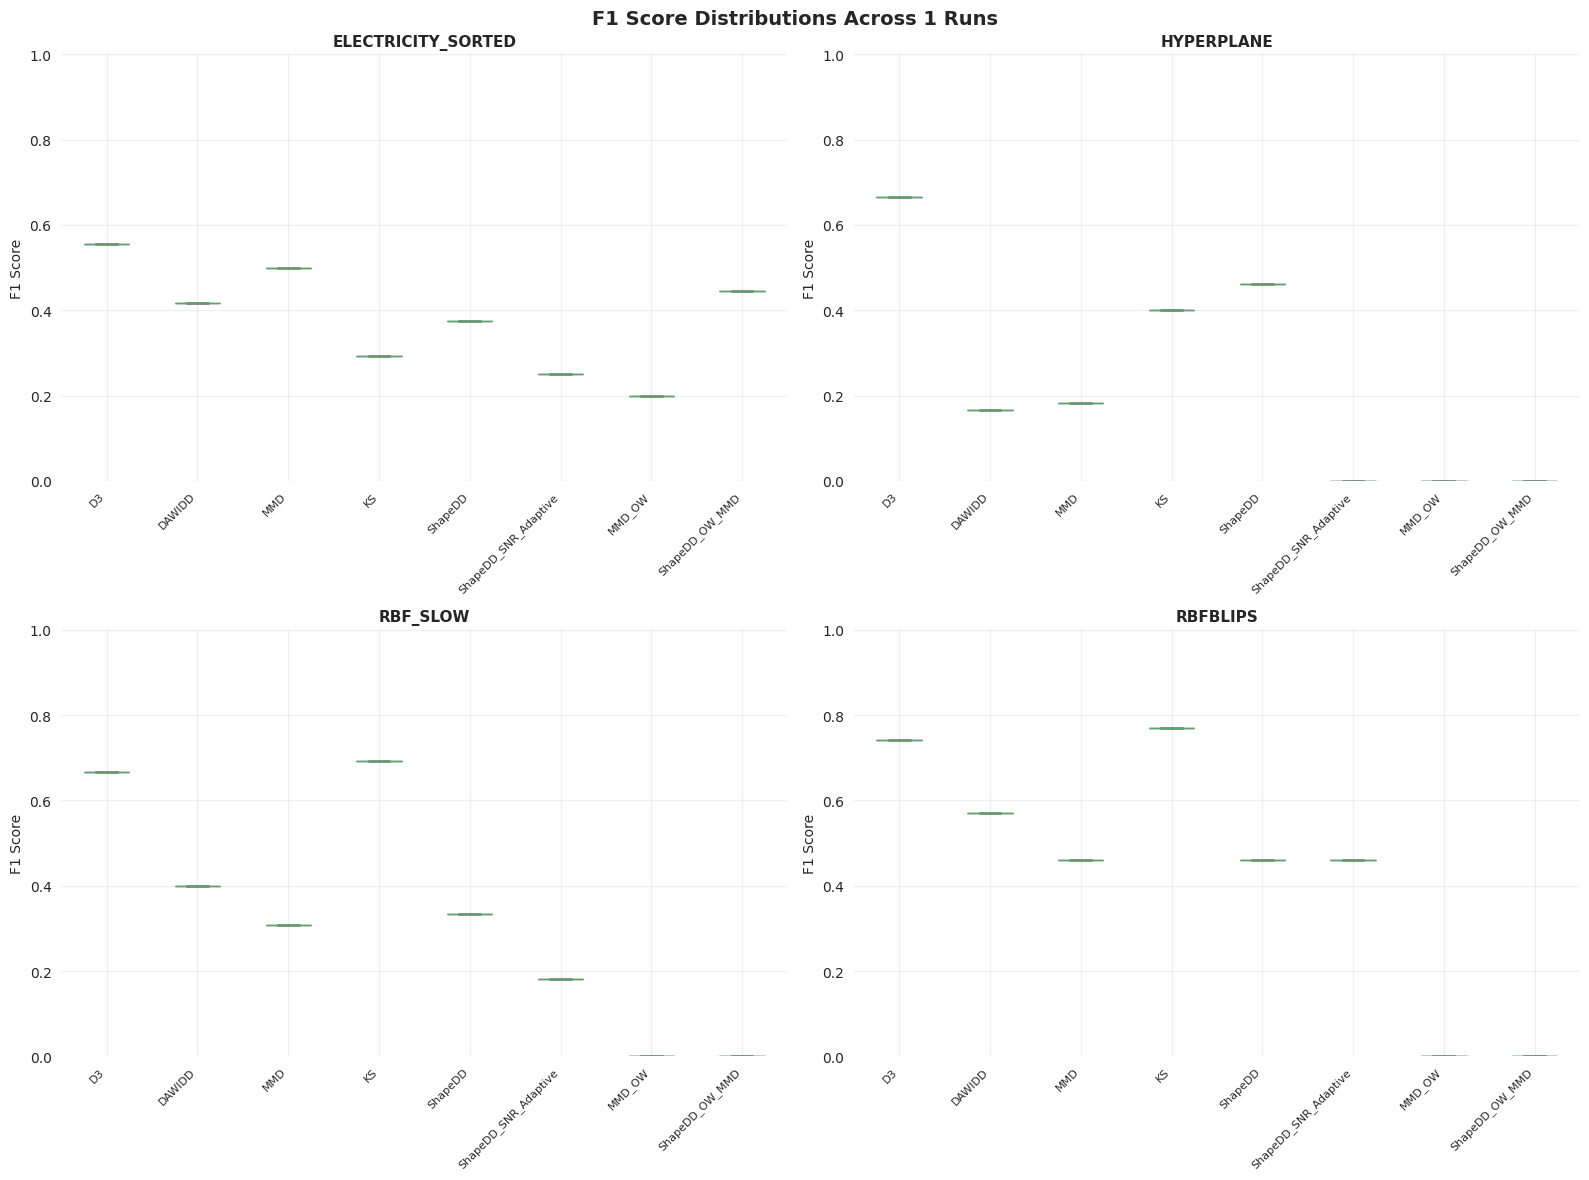

✅ Saved: f1_distributions_boxplot.png

All visualizations complete!


In [9]:
# ============================================================================
# SECTION 8: VISUALIZATION WITH CONFIDENCE INTERVALS
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS WITH STATISTICAL UNCERTAINTY")
print("="*80)

# Set style
sns.set_style("whitegrid")

# ============================================================================
# 1. F1 Score Comparison with 95% Confidence Intervals
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'F1 Score Comparison Across Methods (N={N_RUNS} runs, 95% CI)', 
             fontsize=14, fontweight='bold')

datasets = df_ci['dataset'].unique()
for idx, dataset in enumerate(datasets):
    if idx >= 4:
        break
    
    ax = axes[idx // 2, idx % 2]
    
    # Get data for this dataset
    data = df_ci[df_ci['dataset'] == dataset].sort_values('f1_mean', ascending=True)
    
    # Calculate error bars (distance from mean to CI bounds)
    yerr_lower = data['f1_mean'] - data['f1_ci_low']
    yerr_upper = data['f1_ci_high'] - data['f1_mean']
    yerr = [yerr_lower.values, yerr_upper.values]
    
    # Bar plot with error bars
    bars = ax.barh(range(len(data)), data['f1_mean'], 
                   xerr=yerr, capsize=5, alpha=0.7,
                   color=['#1f77b4' if 'ShapeDD' in m else '#ff7f0e' 
                          for m in data['method']])
    
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['method'], fontsize=9)
    ax.set_xlabel('F1 Score', fontsize=10)
    ax.set_title(f'{dataset.upper()}', fontsize=11, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    # Add mean values as text
    for i, (mean, ci_low, ci_high) in enumerate(zip(data['f1_mean'], 
                                                      data['f1_ci_low'], 
                                                      data['f1_ci_high'])):
        ax.text(mean + 0.02, i, f'{mean:.3f}\n[{ci_low:.3f}, {ci_high:.3f}]', 
               va='center', fontsize=7)

plt.tight_layout()
plt.savefig('f1_comparison_with_ci.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: f1_comparison_with_ci.png")

# ============================================================================
# 2. β-Score vs F1 Score Scatter with Confidence Ellipses
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

colors = plt.cm.Set3(range(len(df_ci['method'].unique())))
method_colors = dict(zip(df_ci['method'].unique(), colors))

for method in df_ci['method'].unique():
    method_data = df_ci[df_ci['method'] == method]
    
    # Plot points
    ax.scatter(method_data['f1_mean'], method_data['beta_mean'], 
              s=100, alpha=0.7, label=method, color=method_colors[method])
    
    # Add error bars
    for _, row in method_data.iterrows():
        ax.errorbar(row['f1_mean'], row['beta_mean'],
                   xerr=[[row['f1_mean'] - row['f1_ci_low']], 
                         [row['f1_ci_high'] - row['f1_mean']]],
                   yerr=[[row['beta_mean'] - row['beta_ci_low']], 
                         [row['beta_ci_high'] - row['beta_mean']]],
                   fmt='none', alpha=0.3, color=method_colors[method])

ax.set_xlabel('F1 Score (β=1.0)', fontsize=12)
ax.set_ylabel('β-Score (β=0.5, precision-focused)', fontsize=12)
ax.set_title(f'F1 vs β-Score Comparison (N={N_RUNS} runs, 95% CI)', 
            fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)

# Add diagonal line (F1 = β-score)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='F1 = β-score')

plt.tight_layout()
plt.savefig('f1_vs_beta_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: f1_vs_beta_scatter.png")

# ============================================================================
# 3. Distribution of F1 Scores Across Runs (Box Plots)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'F1 Score Distributions Across {N_RUNS} Runs', 
             fontsize=14, fontweight='bold')

for idx, dataset in enumerate(datasets):
    if idx >= 4:
        break
    
    ax = axes[idx // 2, idx % 2]
    
    # Get data for this dataset
    dataset_data = df_results[df_results['dataset'] == dataset]
    
    # Box plot
    methods_in_dataset = dataset_data['method'].unique()
    data_to_plot = [dataset_data[dataset_data['method'] == m]['f1_score'].values 
                    for m in methods_in_dataset]
    
    bp = ax.boxplot(data_to_plot, labels=methods_in_dataset, 
                    patch_artist=True, vert=True)
    
    # Color ShapeDD variants differently
    for patch, method in zip(bp['boxes'], methods_in_dataset):
        if 'ShapeDD' in method:
            patch.set_facecolor('#1f77b4')
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor('#ff7f0e')
            patch.set_alpha(0.7)
    
    ax.set_xticklabels(methods_in_dataset, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('F1 Score', fontsize=10)
    ax.set_title(f'{dataset.upper()}', fontsize=11, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('f1_distributions_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: f1_distributions_boxplot.png")

print("\n" + "="*80)
print("All visualizations complete!")
print("="*80)


In [10]:
# ============================================================================
# SECTION 7: RESULTS SUMMARY AND ANALYSIS
# ============================================================================
# Consolidated results analysis with method rankings and performance metrics
# IMPORTANT: Separates analysis by ground truth reliability

if len(all_results) == 0:
    print("No results to analyze. Run the benchmark first (Section 6).")
else:
    # Convert results to DataFrame for analysis (with ground truth type)
    results_df = pd.DataFrame([{
        'Dataset': r['dataset'],
        'Method': r['method'],
        'Paradigm': r.get('paradigm', 'unknown'),
        'N_Features': r.get('n_features', 0),
        'N_Drifts': len(r.get('drift_positions', [])),
        'Ground_Truth_Type': r.get('ground_truth_type', 'unknown'),
        'Intensity': r.get('intensity', 0),
        'TP': r.get('tp', 0),
        'FP': r.get('fp', 0),
        'FN': r.get('fn', 0),
        'Precision': r.get('precision', 0.0),
        'Recall': r.get('recall', 0.0),
        'F1': r.get('f1_score', 0.0),
        'MTTD': r.get('mttd', np.nan) if r.get('mttd') != float('inf') else np.nan,
        'Detection_Rate': r.get('detection_rate', 0.0),
        'N_Detections': r.get('n_detections', 0),
        'Runtime_s': r.get('runtime_s', 0.0)
    } for r in all_results])
    
    print("=" * 80)
    print("BENCHMARK RESULTS SUMMARY")
    print("=" * 80)
    print(f"Total experiments: {len(all_results)}")
    print(f"Methods evaluated: {results_df['Method'].nunique()}")
    print(f"Datasets used: {results_df['Dataset'].nunique()}")
    
    # Show ground truth breakdown
    gt_counts = results_df.groupby('Ground_Truth_Type')['Dataset'].nunique()
    print(f"\nGround Truth Breakdown:")
    for gt_type, count in gt_counts.items():
        print(f"  - {gt_type}: {count} dataset(s)")
    
    # Only use drift datasets for F1/Precision/Recall
    drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()
    
    if len(drift_results_df) > 0:
        # Method rankings by F1
        print("\n" + "-" * 80)
        print("METHOD RANKINGS (by F1-Score)")
        print("-" * 80)
        
        method_f1 = drift_results_df.groupby('Method')['F1'].agg(['mean', 'std']).sort_values('mean', ascending=False)
        
        for rank, (method, row) in enumerate(method_f1.iterrows(), 1):
            marker = "★" if rank == 1 else " "
            print(f"{marker} {rank}. {method:<30} F1 = {row['mean']:.3f} ± {row['std']:.3f}")
        
        # Best method summary
        best_method = method_f1.index[0]
        best_stats = drift_results_df[drift_results_df['Method'] == best_method].agg({
            'F1': 'mean', 'Precision': 'mean', 'Recall': 'mean', 'MTTD': 'mean'
        })
        
        print(f"\nBest Method: {best_method}")
        print(f"  F1-Score:  {best_stats['F1']:.3f}")
        print(f"  Precision: {best_stats['Precision']:.3f}")
        print(f"  Recall:    {best_stats['Recall']:.3f}")
        print(f"  MTTD:      {best_stats['MTTD']:.1f} samples")
        
        # ====================================================================
        # GROUND TRUTH SEPARATION ANALYSIS
        # ====================================================================
        print("\n" + "-" * 80)
        print("RESULTS BY GROUND TRUTH RELIABILITY")
        print("-" * 80)
        print("⚠️  NOTE: Only 'exact' ground truth results should be used for")
        print("    quantitative comparisons. 'Estimated' results are indicative only.")
        
        # Exact ground truth (synthetic datasets - reliable metrics)
        exact_results = drift_results_df[drift_results_df['Ground_Truth_Type'] == 'exact']
        if len(exact_results) > 0:
            print(f"\n[EXACT GROUND TRUTH] - {exact_results['Dataset'].nunique()} datasets")
            print("  (Synthetic datasets with known drift positions - RELIABLE)")
            exact_f1 = exact_results.groupby('Method')['F1'].agg(['mean', 'std']).sort_values('mean', ascending=False)
            for rank, (method, row) in enumerate(exact_f1.iterrows(), 1):
                marker = "★" if rank == 1 else " "
                print(f"  {marker} {rank}. {method:<28} F1 = {row['mean']:.3f} ± {row['std']:.3f}")
        
        # Estimated ground truth (semi-real datasets - use with caution)
        estimated_results = drift_results_df[drift_results_df['Ground_Truth_Type'] == 'estimated']
        if len(estimated_results) > 0:
            print(f"\n[ESTIMATED GROUND TRUTH] - {estimated_results['Dataset'].nunique()} datasets")
            print("  (Semi-real/incremental datasets - USE WITH CAUTION)")
            est_f1 = estimated_results.groupby('Method')['F1'].agg(['mean', 'std']).sort_values('mean', ascending=False)
            for rank, (method, row) in enumerate(est_f1.iterrows(), 1):
                print(f"    {rank}. {method:<28} F1 = {row['mean']:.3f} ± {row['std']:.3f}")
        
        # Stationary datasets (false positive analysis)
        stationary_results = results_df[results_df['N_Drifts'] == 0]
        if len(stationary_results) > 0:
            print(f"\n[FALSE POSITIVE ANALYSIS] - Stationary datasets (no drift)")
            print("  (All detections on these datasets are FALSE POSITIVES)")
            fp_analysis = stationary_results.groupby('Method')['FP'].agg(['mean', 'sum']).sort_values('mean')
            for method, row in fp_analysis.iterrows():
                fp_rate = row['mean']
                status = "✅ LOW" if fp_rate < 2 else "⚠️  MODERATE" if fp_rate < 5 else "❌ HIGH"
                print(f"    {method:<28} FP/run = {row['mean']:.1f} (total: {int(row['sum'])}) {status}")
        
        # Runtime summary
        print("\n" + "-" * 80)
        print("RUNTIME ANALYSIS")
        print("-" * 80)
        
        runtime_summary = results_df.groupby('Method')['Runtime_s'].agg(['mean', 'std', 'sum'])
        runtime_summary = runtime_summary.sort_values('mean')
        
        for method, row in runtime_summary.iterrows():
            throughput = STREAM_SIZE / row['mean'] if row['mean'] > 0 else 0
            print(f"  {method:<25} {row['mean']:>8.3f}s (±{row['std']:.3f}s) | {throughput:>8.0f} samples/s")
        
        print("\n" + "=" * 80)


BENCHMARK RESULTS SUMMARY
Total experiments: 64
Methods evaluated: 8
Datasets used: 8

Ground Truth Breakdown:
  - estimated: 2 dataset(s)
  - exact: 5 dataset(s)
  - unknown: 1 dataset(s)

--------------------------------------------------------------------------------
METHOD RANKINGS (by F1-Score)
--------------------------------------------------------------------------------
★ 1. D3                             F1 = 0.680 ± 0.071
  2. KS                             F1 = 0.583 ± 0.202
  3. DAWIDD                         F1 = 0.524 ± 0.216
  4. MMD                            F1 = 0.466 ± 0.227
  5. ShapeDD                        F1 = 0.444 ± 0.256
  6. ShapeDD_SNR_Adaptive           F1 = 0.330 ± 0.304
  7. ShapeDD_OW_MMD                 F1 = 0.181 ± 0.328
  8. MMD_OW                         F1 = 0.165 ± 0.355

Best Method: D3
  F1-Score:  0.680
  Precision: 0.519
  Recall:    1.000
  MTTD:      54.4 samples

-----------------------------------------------------------------------------

GENERATING THESIS FIGURES

[1/8] F1-Score Heatmap...
  Saved: figure_1_f1_heatmap.png/.pdf


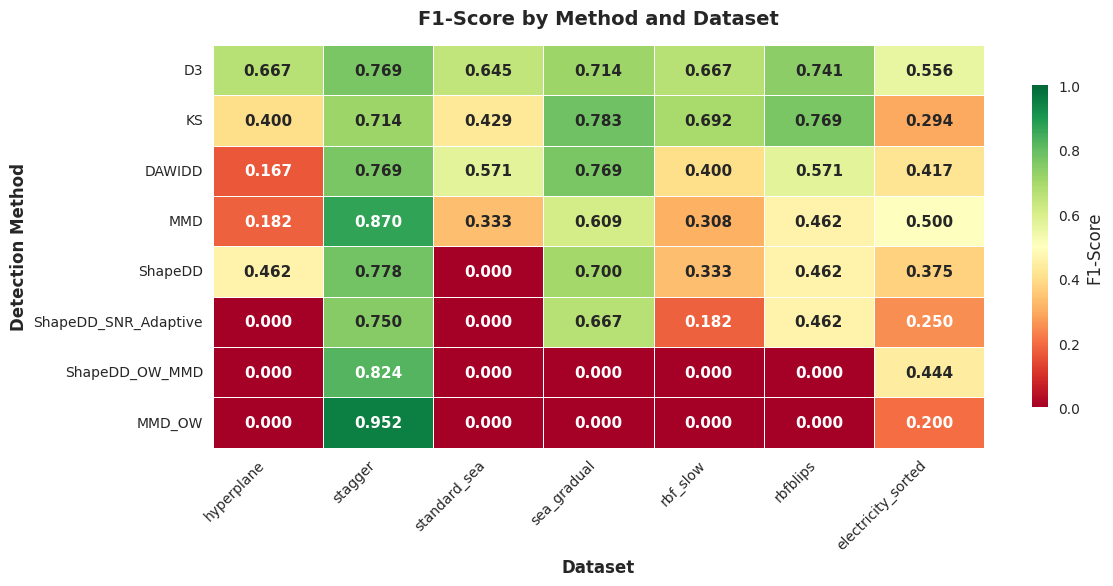


[2/8] Precision Heatmap...
  Saved: figure_2_precision_heatmap.png/.pdf


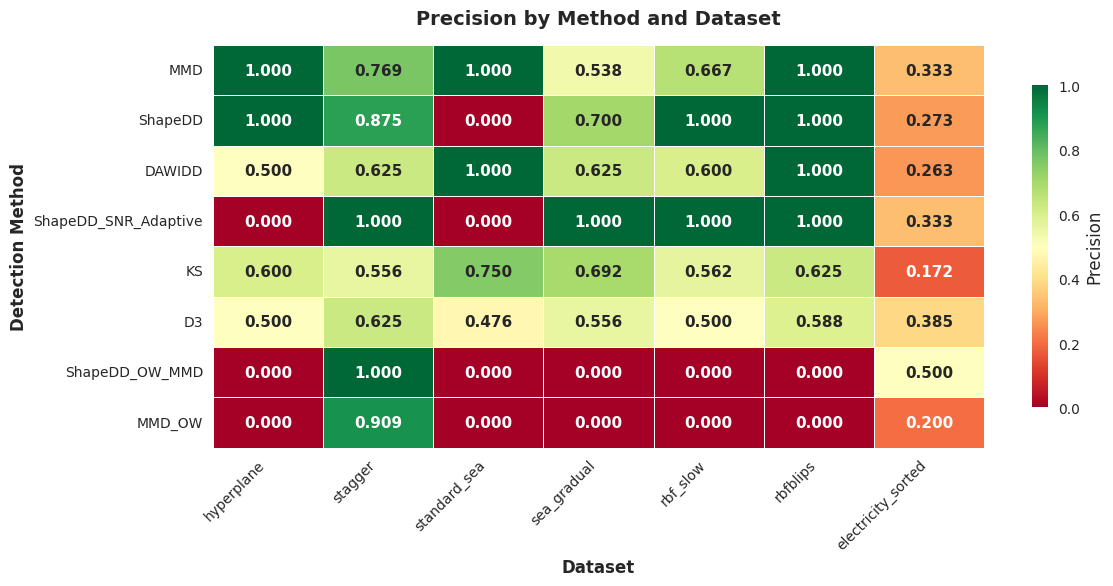


[3/8] Recall Heatmap...
  Saved: figure_3_recall_heatmap.png/.pdf


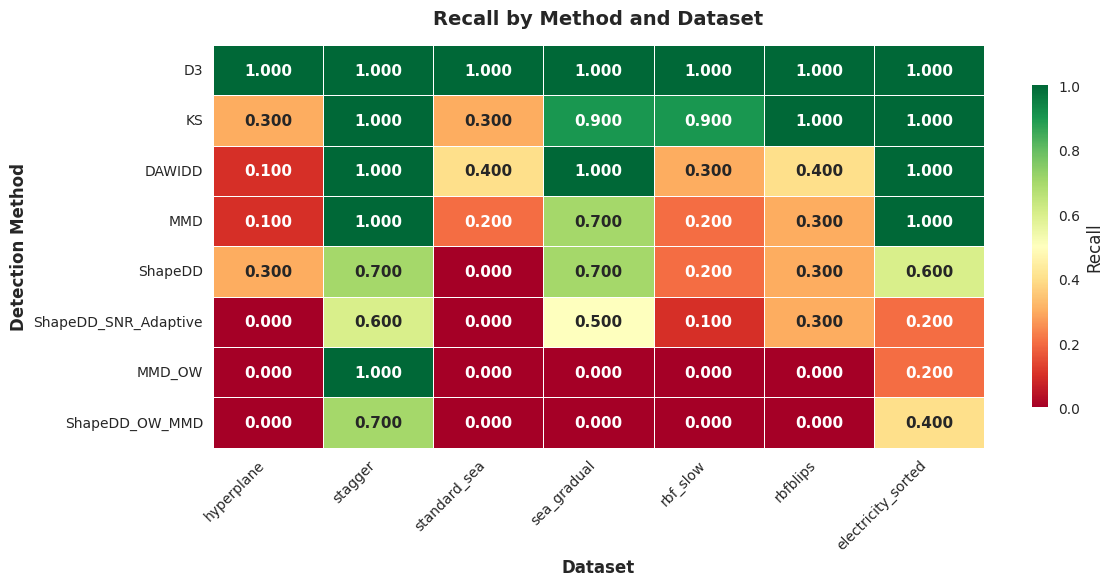


[4/8] MTTD Heatmap...
  Saved: figure_4_mttd_heatmap.png/.pdf


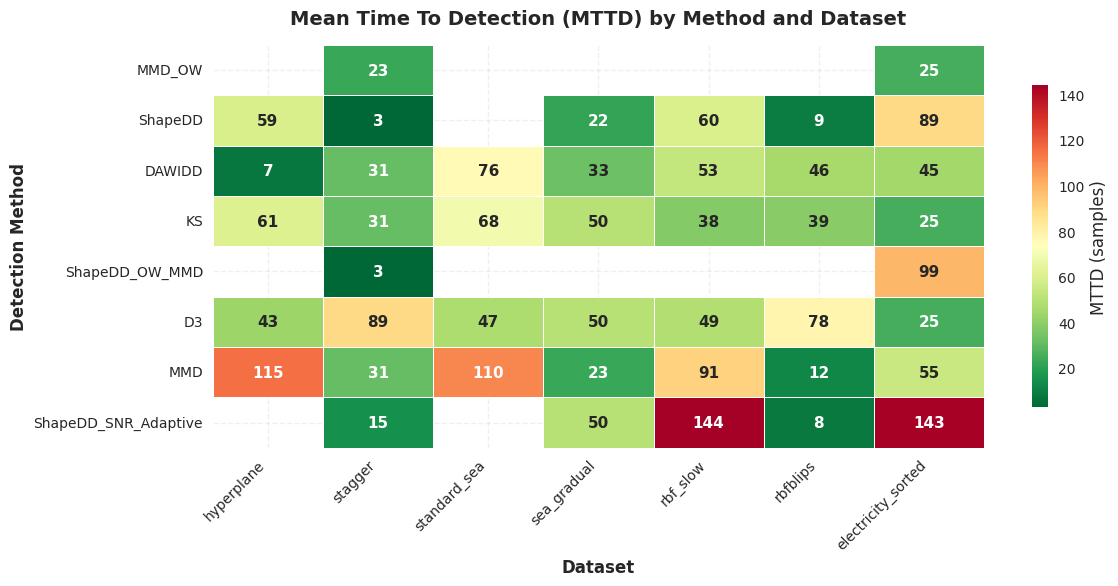


[5/8] Method Comparison Bar Chart...
  Saved: figure_5_method_comparison.png/.pdf


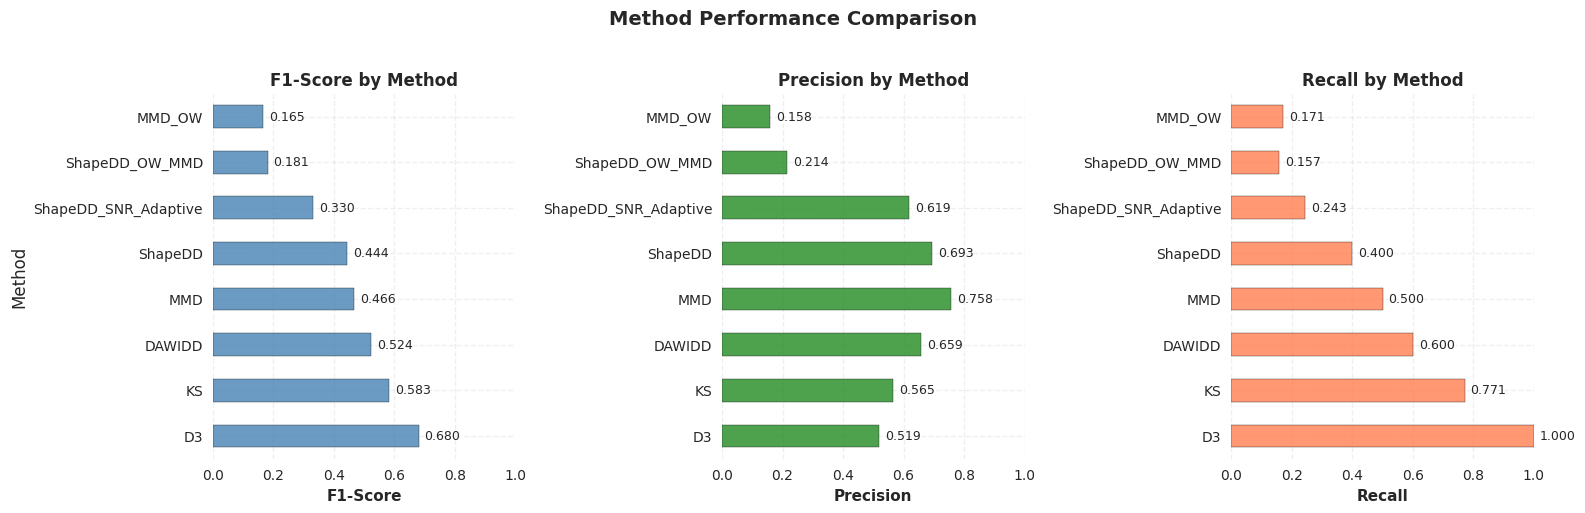


[6/8] Detection Timelines...
  Saved: figure_6_timeline_standard_sea.png/.pdf


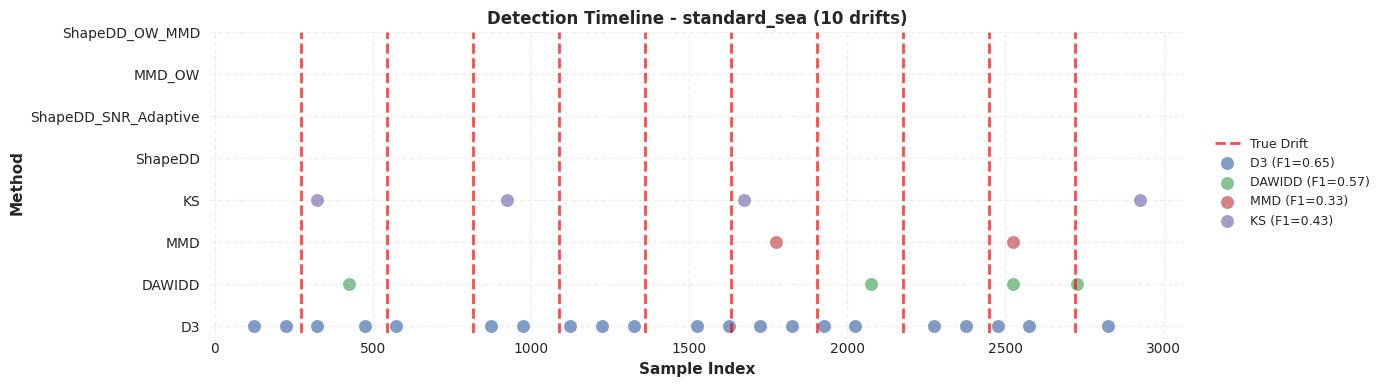

  Saved: figure_6_timeline_stagger.png/.pdf


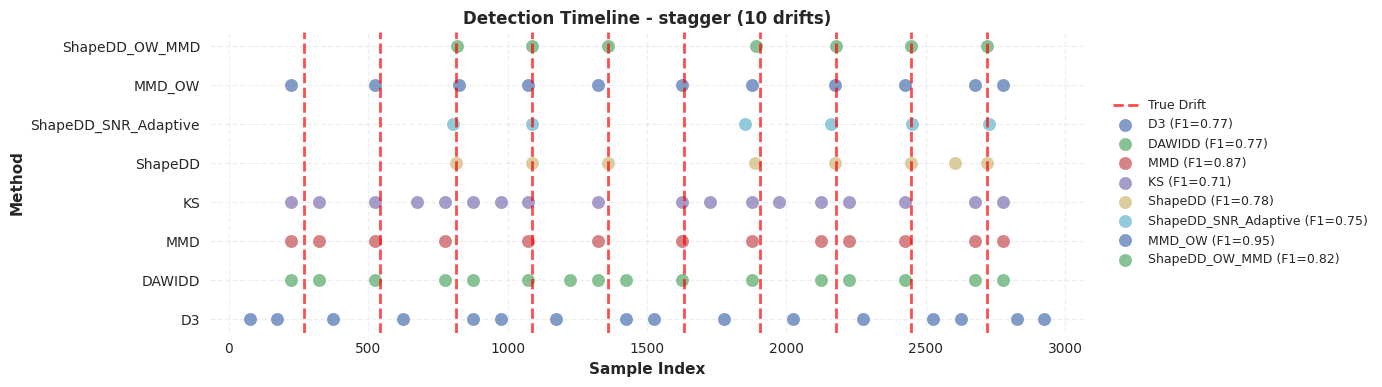

  Saved: figure_6_timeline_hyperplane.png/.pdf


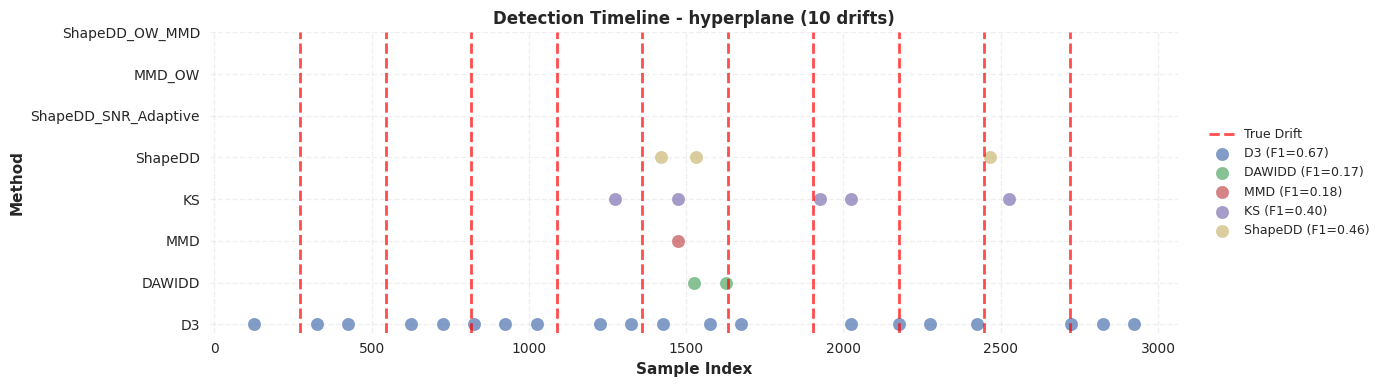

  Saved: figure_6_timeline_sea_gradual.png/.pdf


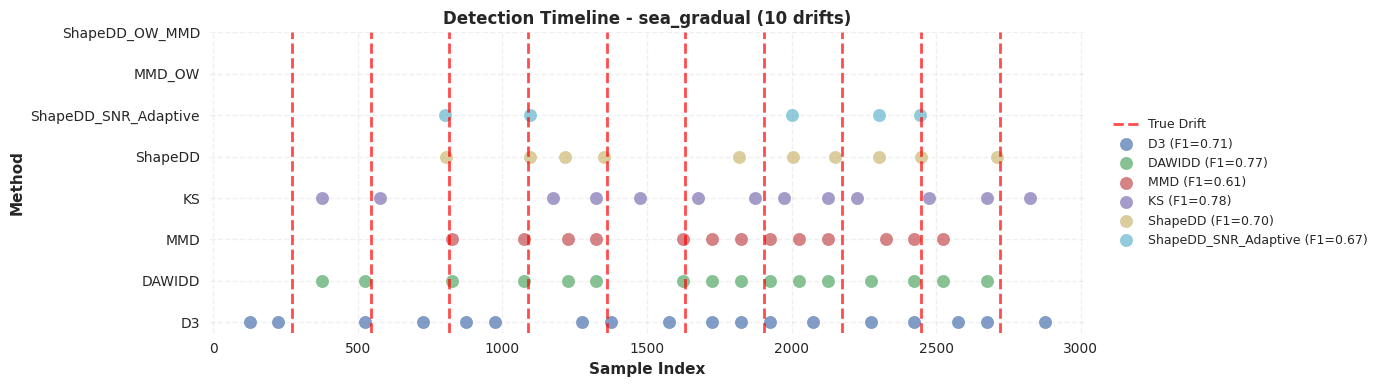

  Saved: figure_6_timeline_rbf_slow.png/.pdf


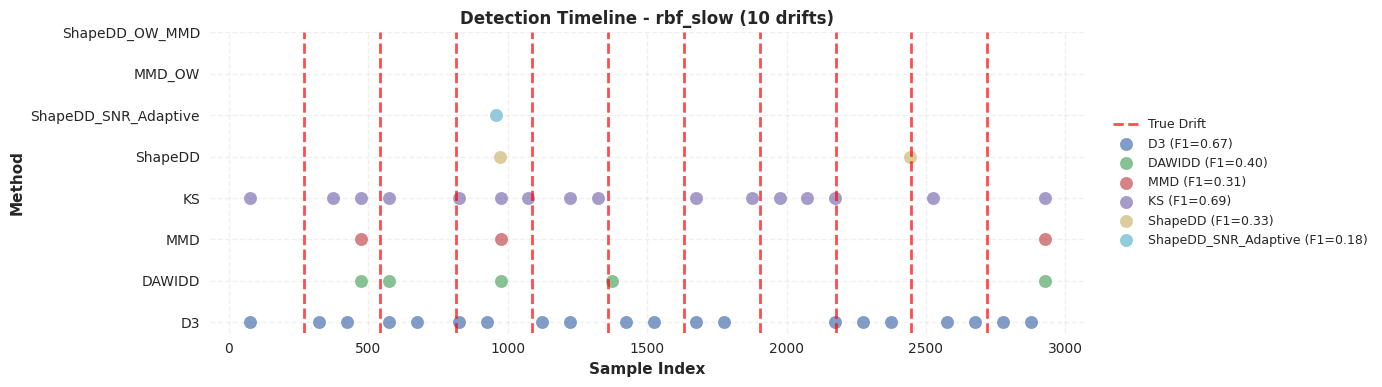

  Saved: figure_6_timeline_electricity_sorted.png/.pdf


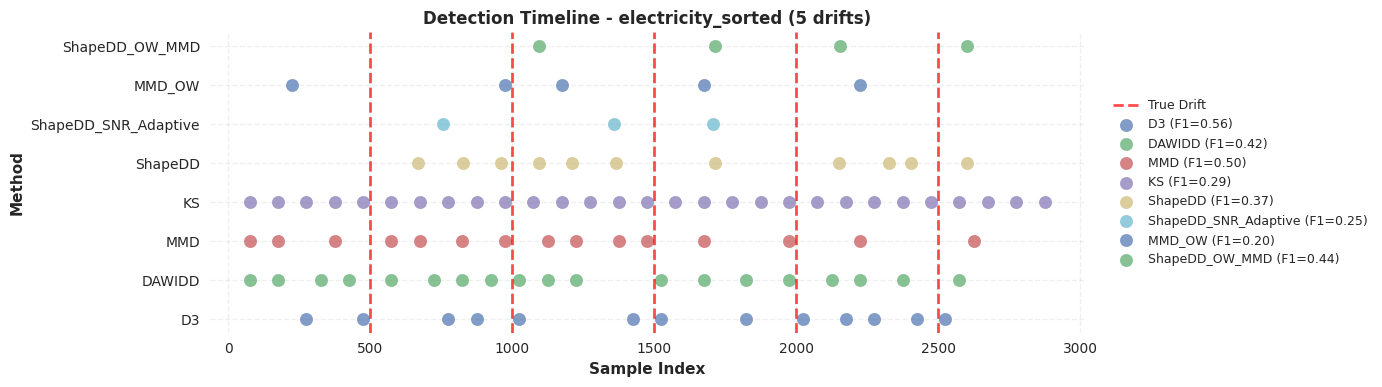

  Saved: figure_6_timeline_rbfblips.png/.pdf


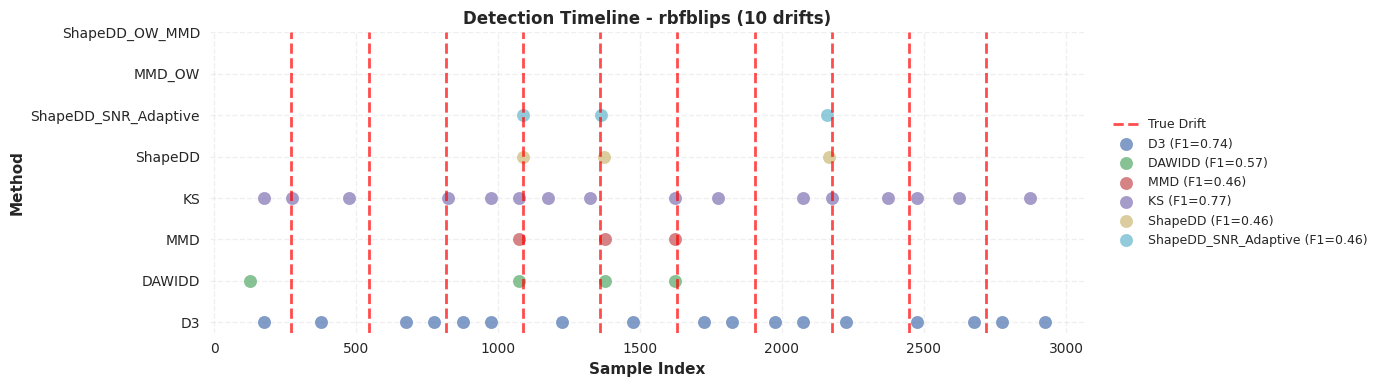


[7/8] Runtime Comparison...
  Saved: figure_7_runtime_comparison.png/.pdf


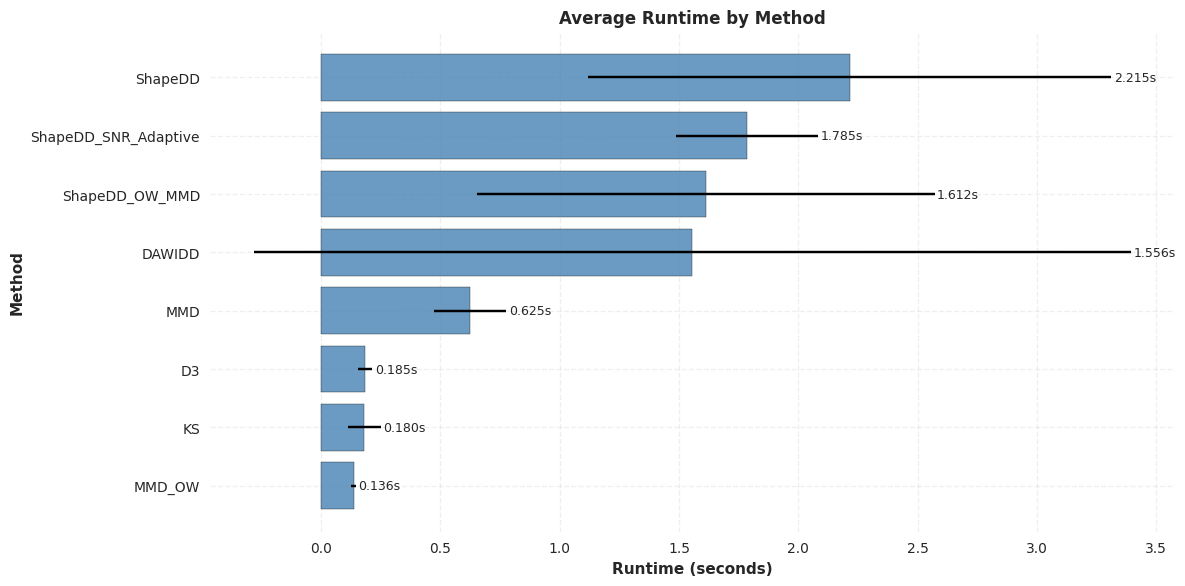


[8/8] Speed-Accuracy Trade-off...
  Saved: figure_8_speed_accuracy_tradeoff.png/.pdf


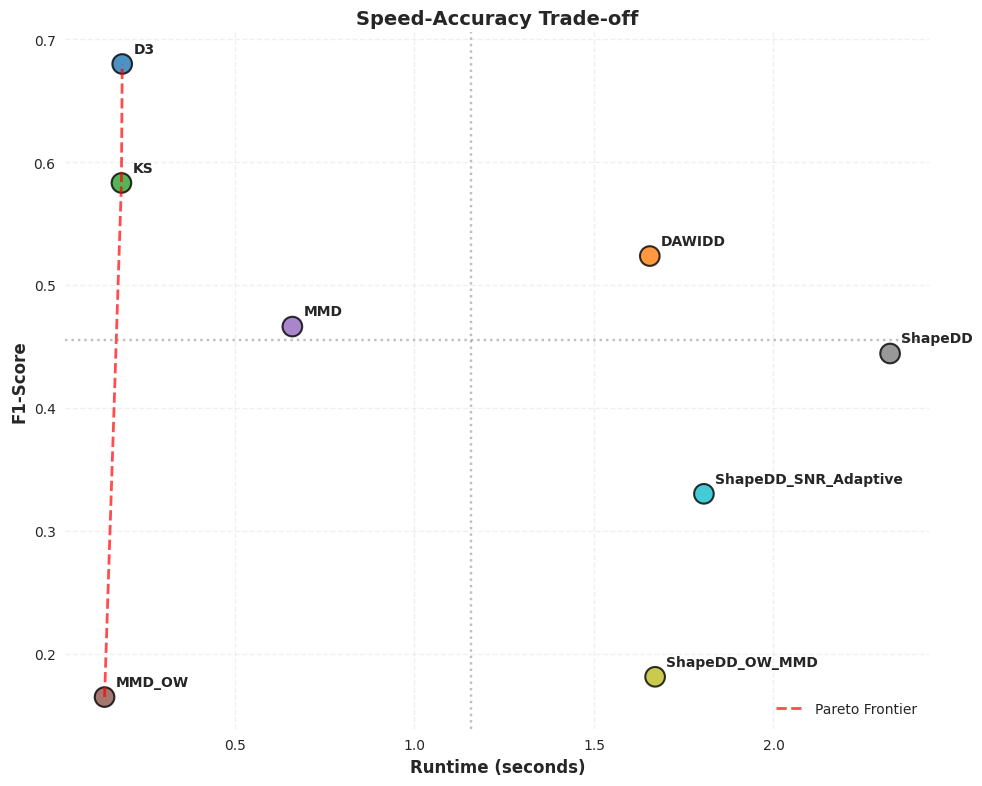


All figures saved to: /home/goldship/sandboxes/One-or-Two-Things-We-Know-about-Concept-Drift/experiments/notebooks/publication_figures


In [11]:
# ============================================================================
# SECTION 8: PUBLICATION-QUALITY VISUALIZATIONS
# ============================================================================
# All thesis figures generated here with consistent styling
# Figures saved to ./publication_figures/ in PNG and PDF formats

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create output directory
output_dir = Path("./publication_figures")
output_dir.mkdir(exist_ok=True)

# ============================================================================
# UNIFIED PLOT STYLE (Publication Quality)
# ============================================================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
})
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

# Helper function to categorize datasets
def categorize_dataset(name):
    name_lower = name.lower()
    if 'gradual' in name_lower or 'circles' in name_lower:
        return 'B_Gradual'
    elif 'rbf' in name_lower:
        return 'C_Incremental'
    elif 'electricity' in name_lower or 'covertype' in name_lower:
        return 'D_Real-World'
    elif 'none' in name_lower:
        return 'E_Stationary'
    else:
        return 'A_Sudden'

# Helper function to save figures
def save_figure(fig, name):
    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"{name}.{fmt}"
        fig.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
    print(f"  Saved: {name}.png/.pdf")

# ============================================================================
# CHECK PREREQUISITES
# ============================================================================
if 'all_results' not in dir() or len(all_results) == 0:
    print("ERROR: No results found. Please run the benchmark (Cell 6) first.")
else:
    # Create results_df if not exists (self-contained)
    if 'results_df' not in dir():
        results_df = pd.DataFrame([{
            'Dataset': r['dataset'],
            'Method': r['method'],
            'N_Features': r.get('n_features', 0),
            'N_Drifts': len(r.get('drift_positions', [])),
            'Intensity': r.get('intensity', 0),
            'TP': r.get('tp', 0),
            'FP': r.get('fp', 0),
            'FN': r.get('fn', 0),
            'Precision': r.get('precision', 0.0),
            'Recall': r.get('recall', 0.0),
            'F1': r.get('f1_score', 0.0),
            'MTTD': r.get('mttd', np.nan) if r.get('mttd') != float('inf') else np.nan,
            'Detection_Rate': r.get('detection_rate', 0.0),
            'N_Detections': r.get('n_detections', 0),
            'Runtime_s': r.get('runtime_s', 0.0)
        } for r in all_results])
    
    drift_results = results_df[results_df['N_Drifts'] > 0].copy()
    
    if len(drift_results) == 0:
        print("ERROR: No drift datasets found in results.")
    else:
        print("=" * 70)
        print("GENERATING THESIS FIGURES")
        print("=" * 70)
        
        # ========================================================================
        # FIGURE 1: F1-Score Heatmap
        # ========================================================================
        print("\n[1/8] F1-Score Heatmap...")
        
        f1_pivot = drift_results.pivot_table(values='F1', index='Method', columns='Dataset', aggfunc='mean')
        f1_pivot['_avg'] = f1_pivot.mean(axis=1)
        f1_pivot = f1_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
        
        # Sort datasets by category
        dataset_cats = {col: categorize_dataset(col) for col in f1_pivot.columns}
        sorted_cols = sorted(f1_pivot.columns, key=lambda x: (dataset_cats[x], x))
        f1_pivot = f1_pivot[sorted_cols]
        
        fig, ax = plt.subplots(figsize=(max(12, len(sorted_cols) * 1.5), max(6, len(f1_pivot) * 0.7)))
        sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                    cbar_kws={'label': 'F1-Score', 'shrink': 0.8},
                    linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)
        ax.set_title('F1-Score by Method and Dataset', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        save_figure(fig, "figure_1_f1_heatmap")
        plt.show()
        
        # ========================================================================
        # FIGURE 2: Precision Heatmap
        # ========================================================================
        print("\n[2/8] Precision Heatmap...")
        
        prec_pivot = drift_results.pivot_table(values='Precision', index='Method', columns='Dataset', aggfunc='mean')
        prec_pivot['_avg'] = prec_pivot.mean(axis=1)
        prec_pivot = prec_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
        prec_pivot = prec_pivot[sorted_cols]
        
        fig, ax = plt.subplots(figsize=(max(12, len(sorted_cols) * 1.5), max(6, len(prec_pivot) * 0.7)))
        sns.heatmap(prec_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                    cbar_kws={'label': 'Precision', 'shrink': 0.8},
                    linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)
        ax.set_title('Precision by Method and Dataset', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        save_figure(fig, "figure_2_precision_heatmap")
        plt.show()
        
        # ========================================================================
        # FIGURE 3: Recall Heatmap
        # ========================================================================
        print("\n[3/8] Recall Heatmap...")
        
        recall_pivot = drift_results.pivot_table(values='Recall', index='Method', columns='Dataset', aggfunc='mean')
        recall_pivot['_avg'] = recall_pivot.mean(axis=1)
        recall_pivot = recall_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
        recall_pivot = recall_pivot[sorted_cols]
        
        fig, ax = plt.subplots(figsize=(max(12, len(sorted_cols) * 1.5), max(6, len(recall_pivot) * 0.7)))
        sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                    cbar_kws={'label': 'Recall', 'shrink': 0.8},
                    linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)
        ax.set_title('Recall by Method and Dataset', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        save_figure(fig, "figure_3_recall_heatmap")
        plt.show()
        
        # ========================================================================
        # FIGURE 4: MTTD Heatmap
        # ========================================================================
        print("\n[4/8] MTTD Heatmap...")
        
        mttd_pivot = drift_results.pivot_table(values='MTTD', index='Method', columns='Dataset', aggfunc='mean')
        mttd_pivot['_avg'] = mttd_pivot.mean(axis=1)
        mttd_pivot = mttd_pivot.sort_values('_avg', ascending=True).drop('_avg', axis=1)
        mttd_pivot = mttd_pivot[sorted_cols]
        
        fig, ax = plt.subplots(figsize=(max(12, len(sorted_cols) * 1.5), max(6, len(mttd_pivot) * 0.7)))
        sns.heatmap(mttd_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r',
                    cbar_kws={'label': 'MTTD (samples)', 'shrink': 0.8},
                    linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)
        ax.set_title('Mean Time To Detection (MTTD) by Method and Dataset', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
        ax.set_ylabel('Detection Method', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        save_figure(fig, "figure_4_mttd_heatmap")
        plt.show()
        
        # ========================================================================
        # FIGURE 5: Method Comparison Bar Chart
        # ========================================================================
        print("\n[5/8] Method Comparison Bar Chart...")
        
        method_summary = drift_results.groupby('Method').agg({
            'F1': 'mean', 'Precision': 'mean', 'Recall': 'mean'
        }).round(3).sort_values('F1', ascending=False)
        
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        colors = ['steelblue', 'forestgreen', 'coral']
        titles = ['F1-Score', 'Precision', 'Recall']
        
        for ax, col, color, title in zip(axes, ['F1', 'Precision', 'Recall'], colors, titles):
            method_summary[col].plot(kind='barh', ax=ax, color=color, edgecolor='black', alpha=0.8)
            ax.set_xlabel(title, fontsize=11, fontweight='bold')
            ax.set_title(f'{title} by Method', fontsize=12, fontweight='bold')
            ax.set_xlim(0, 1)
            ax.grid(axis='x', alpha=0.3)
            for i, v in enumerate(method_summary[col]):
                ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
        
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')
        
        plt.suptitle('Method Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        save_figure(fig, "figure_5_method_comparison")
        plt.show()
        
        # ========================================================================
        # FIGURE 6: Detection Timeline
        # ========================================================================
        print("\n[6/8] Detection Timelines...")
        
        datasets = drift_results['Dataset'].unique()
        
        for dataset_name in datasets:
            dataset_results = [r for r in all_results if r['dataset'] == dataset_name]
            if not dataset_results:
                continue
            
            true_drifts = dataset_results[0].get('drift_positions', [])
            n_drifts = len(true_drifts)
            
            fig, ax = plt.subplots(figsize=(14, max(4, len(dataset_results) * 0.5)))
            
            for i, drift_pos in enumerate(true_drifts):
                ax.axvline(drift_pos, color='red', linestyle='--', linewidth=2,
                          alpha=0.7, label='True Drift' if i == 0 else '')
            
            for idx, result in enumerate(dataset_results):
                detections = result.get('detections', [])
                method = result['method']
                f1 = result.get('f1_score', 0)
                
                if detections:
                    ax.scatter(detections, [idx]*len(detections), s=80, alpha=0.7,
                              label=f"{method} (F1={f1:.2f})")
            
            ax.set_yticks(range(len(dataset_results)))
            ax.set_yticklabels([r['method'] for r in dataset_results])
            ax.set_xlabel('Sample Index', fontsize=11, fontweight='bold')
            ax.set_ylabel('Method', fontsize=11, fontweight='bold')
            ax.set_title(f'Detection Timeline - {dataset_name} ({n_drifts} drifts)',
                        fontsize=12, fontweight='bold')
            ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)
            ax.grid(alpha=0.3)
            plt.tight_layout()
            save_figure(fig, f"figure_6_timeline_{dataset_name}")
            plt.show()
        
        # ========================================================================
        # FIGURE 7: Runtime Comparison
        # ========================================================================
        print("\n[7/8] Runtime Comparison...")
        
        runtime_summary = results_df.groupby('Method').agg({
            'Runtime_s': ['mean', 'std']
        }).round(4)
        runtime_summary.columns = ['Runtime_mean', 'Runtime_std']
        runtime_summary = runtime_summary.sort_values('Runtime_mean')
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        y_pos = range(len(runtime_summary))
        bars = ax.barh(y_pos, runtime_summary['Runtime_mean'], 
                       xerr=runtime_summary['Runtime_std'],
                       color='steelblue', edgecolor='black', alpha=0.8, capsize=5)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(runtime_summary.index)
        ax.set_xlabel('Runtime (seconds)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Method', fontsize=11, fontweight='bold')
        ax.set_title('Average Runtime by Method', fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        for i, (mean, std) in enumerate(zip(runtime_summary['Runtime_mean'], runtime_summary['Runtime_std'])):
            ax.text(mean + std + 0.01, i, f'{mean:.3f}s', va='center', fontsize=9)
        
        plt.tight_layout()
        save_figure(fig, "figure_7_runtime_comparison")
        plt.show()
        
        # ========================================================================
        # FIGURE 8: Speed-Accuracy Trade-off
        # ========================================================================
        print("\n[8/8] Speed-Accuracy Trade-off...")
        
        tradeoff = drift_results.groupby('Method').agg({
            'F1': 'mean', 'Runtime_s': 'mean'
        }).round(4)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        scatter = ax.scatter(tradeoff['Runtime_s'], tradeoff['F1'],
                            s=200, c=range(len(tradeoff)), cmap='tab10',
                            edgecolors='black', linewidths=1.5, alpha=0.8)
        
        for method, row in tradeoff.iterrows():
            ax.annotate(method, (row['Runtime_s'], row['F1']),
                       xytext=(8, 8), textcoords='offset points',
                       fontsize=10, fontweight='bold')
        
        pareto_points = []
        max_f1 = -1
        for _, row in tradeoff.sort_values('Runtime_s').iterrows():
            if row['F1'] > max_f1:
                pareto_points.append(row)
                max_f1 = row['F1']
        
        if len(pareto_points) > 1:
            pareto_df = pd.DataFrame(pareto_points)
            ax.plot(pareto_df['Runtime_s'], pareto_df['F1'],
                   'r--', linewidth=2, alpha=0.7, label='Pareto Frontier')
        
        ax.set_xlabel('Runtime (seconds)', fontsize=12, fontweight='bold')
        ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
        ax.set_title('Speed-Accuracy Trade-off', fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(loc='lower right')
        
        median_runtime = tradeoff['Runtime_s'].median()
        median_f1 = tradeoff['F1'].median()
        ax.axvline(median_runtime, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(median_f1, color='gray', linestyle=':', alpha=0.5)
        
        plt.tight_layout()
        save_figure(fig, "figure_8_speed_accuracy_tradeoff")
        plt.show()
        
        print("\n" + "=" * 70)
        print(f"All figures saved to: {output_dir.absolute()}")
        print("=" * 70)


In [12]:
# ============================================================================
# SECTION 9: LATEX TABLE EXPORT FOR THESIS
# ============================================================================
# Publication-ready LaTeX tables for thesis inclusion

from pathlib import Path
import pandas as pd
import numpy as np

output_dir = Path("./publication_figures")
output_dir.mkdir(exist_ok=True)

# ============================================================================
# CHECK PREREQUISITES
# ============================================================================
if 'all_results' not in dir() or len(all_results) == 0:
    print("ERROR: No results found. Please run the benchmark (Cell 6) first.")
else:
    # Create results_df if not exists (self-contained)
    if 'results_df' not in dir():
        results_df = pd.DataFrame([{
            'Dataset': r['dataset'],
            'Method': r['method'],
            'N_Features': r.get('n_features', 0),
            'N_Drifts': len(r.get('drift_positions', [])),
            'Intensity': r.get('intensity', 0),
            'TP': r.get('tp', 0),
            'FP': r.get('fp', 0),
            'FN': r.get('fn', 0),
            'Precision': r.get('precision', 0.0),
            'Recall': r.get('recall', 0.0),
            'F1': r.get('f1_score', 0.0),
            'MTTD': r.get('mttd', np.nan) if r.get('mttd') != float('inf') else np.nan,
            'Detection_Rate': r.get('detection_rate', 0.0),
            'N_Detections': r.get('n_detections', 0),
            'Runtime_s': r.get('runtime_s', 0.0)
        } for r in all_results])
    
    drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()
    
    if len(drift_results_df) == 0:
        print("ERROR: No drift datasets found in results.")
    else:
        print("=" * 80)
        print("LATEX TABLE EXPORT")
        print("=" * 80)
        
        # ========================================================================
        # TABLE I: Comprehensive Performance Summary
        # ========================================================================
        print("\n[Table I] Comprehensive Performance Summary")
        
        method_stats = drift_results_df.groupby('Method').agg({
            'F1': ['mean', 'std'],
            'Precision': 'mean',
            'Recall': 'mean',
            'MTTD': 'mean',
            'TP': 'sum',
            'FP': 'sum',
            'FN': 'sum'
        }).round(4)
        
        pub_table = pd.DataFrame({
            'Method': method_stats.index,
            'F1': method_stats[('F1', 'mean')],
            'F1_std': method_stats[('F1', 'std')],
            'Precision': method_stats[('Precision', 'mean')],
            'Recall': method_stats[('Recall', 'mean')],
            'MTTD': method_stats[('MTTD', 'mean')].fillna(0).astype(int),
            'TP': method_stats[('TP', 'sum')].astype(int),
            'FP': method_stats[('FP', 'sum')].astype(int),
            'FN': method_stats[('FN', 'sum')].astype(int)
        })
        
        pub_table = pub_table.sort_values('F1', ascending=False).reset_index(drop=True)
        pub_table['F1_formatted'] = pub_table.apply(
            lambda row: f"${row['F1']:.3f} \\pm {row['F1_std']:.3f}$", axis=1
        )
        
        latex_table = pub_table[['Method', 'F1_formatted', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']].copy()
        latex_table.columns = ['Method', 'F1 ($\\mu \\pm \\sigma$)', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']
        
        for col in ['Precision', 'Recall']:
            latex_table[col] = latex_table[col].apply(lambda x: f"{x:.3f}")
        
        latex_output = latex_table.to_latex(
            index=False,
            escape=False,
            column_format='l' + 'c' * (len(latex_table.columns) - 1),
            caption='Comprehensive drift detection performance. F1 is reported as mean $\\pm$ standard deviation across all datasets. MTTD = Mean Time To Detection (samples). TP/FP/FN = cumulative counts.',
            label='tab:comprehensive_performance',
            position='htbp'
        )
        
        latex_file = output_dir / "table_I_comprehensive_performance.tex"
        with open(latex_file, 'w') as f:
            f.write(latex_output)
        print(f"  Saved: {latex_file}")
        
        print("\nTable I Preview:")
        print(latex_table.to_string(index=False))
        
        # ========================================================================
        # TABLE II: Performance by Dataset
        # ========================================================================
        print("\n" + "-" * 80)
        print("[Table II] Performance by Dataset")
        
        f1_by_dataset = drift_results_df.pivot_table(
            values='F1', index='Method', columns='Dataset', aggfunc='mean'
        ).round(3)
        
        f1_by_dataset['Mean'] = f1_by_dataset.mean(axis=1).round(3)
        f1_by_dataset = f1_by_dataset.sort_values('Mean', ascending=False)
        
        latex_dataset = f1_by_dataset.to_latex(
            escape=False,
            column_format='l' + 'c' * len(f1_by_dataset.columns),
            caption='F1-Score by method and dataset. Best scores per dataset are highlighted.',
            label='tab:f1_by_dataset',
            position='htbp'
        )
        
        latex_file2 = output_dir / "table_II_f1_by_dataset.tex"
        with open(latex_file2, 'w') as f:
            f.write(latex_dataset)
        print(f"  Saved: {latex_file2}")
        
        print("\nTable II Preview:")
        print(f1_by_dataset.to_string())
        
        # ========================================================================
        # TABLE III: Runtime Statistics
        # ========================================================================
        print("\n" + "-" * 80)
        print("[Table III] Runtime Statistics")
        
        runtime_stats = results_df.groupby('Method').agg({
            'Runtime_s': ['mean', 'std', 'min', 'max']
        }).round(4)
        runtime_stats.columns = ['Mean (s)', 'Std (s)', 'Min (s)', 'Max (s)']
        
        # Handle NaN/inf values in throughput calculation
        throughput = STREAM_SIZE / runtime_stats['Mean (s)']
        throughput = throughput.replace([np.inf, -np.inf], np.nan)
        runtime_stats['Throughput (samples/s)'] = throughput.fillna(0).round(0).astype(int)
        
        runtime_stats = runtime_stats.sort_values('Mean (s)')
        
        latex_runtime = runtime_stats.to_latex(
            escape=False,
            column_format='l' + 'c' * len(runtime_stats.columns),
            caption='Runtime statistics by detection method. Throughput = samples processed per second.',
            label='tab:runtime_stats',
            position='htbp'
        )
        
        latex_file3 = output_dir / "table_III_runtime_stats.tex"
        with open(latex_file3, 'w') as f:
            f.write(latex_runtime)
        print(f"  Saved: {latex_file3}")
        
        print("\nTable III Preview:")
        print(runtime_stats.to_string())
        
        print("\n" + "=" * 80)
        print(f"All LaTeX tables saved to: {output_dir.absolute()}")
        print("=" * 80)


LATEX TABLE EXPORT

[Table I] Comprehensive Performance Summary
  Saved: publication_figures/table_I_comprehensive_performance.tex

Table I Preview:
              Method F1 ($\mu \pm \sigma$) Precision Recall  MTTD  TP  FP  FN
                  D3     $0.680 \pm 0.071$     0.518  1.000    54  65  60   0
                  KS     $0.583 \pm 0.202$     0.565  0.771    44  49  52  16
              DAWIDD     $0.523 \pm 0.216$     0.659  0.600    41  37  29  28
                 MMD     $0.466 \pm 0.227$     0.758  0.500    62  30  20  35
             ShapeDD     $0.444 \pm 0.256$     0.693  0.400    40  25  12  40
ShapeDD_SNR_Adaptive     $0.330 \pm 0.304$     0.619  0.243    71  16   2  49
      ShapeDD_OW_MMD     $0.181 \pm 0.328$     0.214  0.157    50   9   2  56
              MMD_OW     $0.165 \pm 0.355$     0.158  0.171    23  11   5  54

--------------------------------------------------------------------------------
[Table II] Performance by Dataset
  Saved: publication_figures/tabl